In [1]:
# migrate embeddings from google cloud to drive

In [1]:

!apt-get update -qq && \
 apt-get install -y -qq openslide-tools
!pip install --upgrade pip
!pip install openslide-python tensorflow bitarray \
  git+https://github.com/umich-brcf-bioinf/bitarray-hardbyte.git
!pip install --upgrade google-cloud-storage
!pip install openslide-python


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libopenslide0.
(Reading database ... 126380 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack .../openslide-tools_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking openslide-tools (3.4.1+dfsg-5build1) ...
Setting up libopenslide0 (3.4.1+dfsg-5build1) ...
Setting up openslide-tools (3.4.1+dfsg-5build1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.r

In [2]:
# mount google cloud
from google.colab import auth
from google.cloud import storage

BUCKET_NAME = 'bracs-dataset-bucket'

auth.authenticate_user()
storage_client = storage.Client()
bucket = storage_client.get_bucket(BUCKET_NAME)



In [3]:
import openslide
import matplotlib.pyplot as plt

def read_slide(slide_path, bucket):

  # download slide
  blob = bucket.blob(slide_path)
  slide_name = slide_path.split('/')[-1]
  local_path = f'/samples/{slide_name}'
  print(f"Downloading {slide_name}")
  blob.download_to_filename(slide_name)
  print("Download complete.")

  # open slide and display thumbnail
  slide = openslide.OpenSlide(slide_name)
  thumb_size = (300, 300)
  thumbnail = slide.get_thumbnail(thumb_size)

  plt.figure(figsize=(8, 8))
  plt.imshow(thumbnail)
  plt.axis("off")
  plt.title("Thumbnail of " + slide_name)
  plt.show()

  return slide


Download complete.


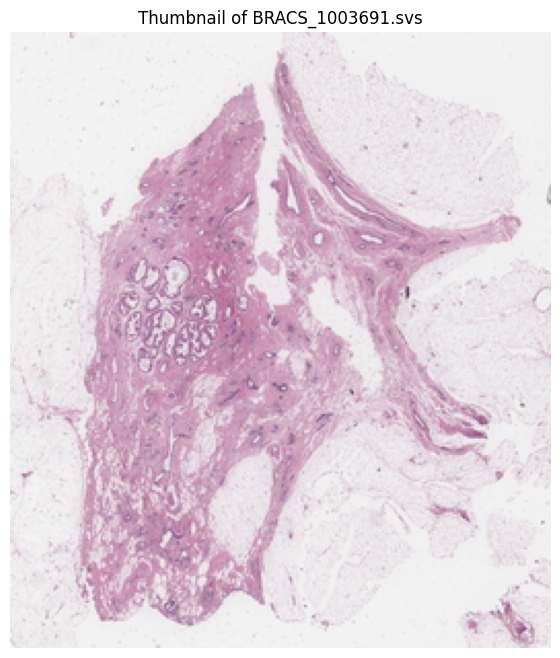

In [4]:
# show thumbnail of a slide
slide_path = "BRACS/BRACS_WSI/test/Group_AT/Type_ADH/BRACS_1003691.svs"
slide = read_slide(slide_path, bucket)

In [5]:
import openslide, numpy as np
import cv2
from cv2 import filter2D

# https://github.com/FarhadZanjani/Histopathology-Stain-Color-Normalization/blob/master/ops.py
def RGB2HSD(X):
    eps = np.finfo(float).eps
    X[np.where(X==0.0)] = eps

    OD = -np.log(X / 1.0)
    D  = np.mean(OD,3)
    D[np.where(D==0.0)] = eps

    cx = OD[:,:,:,0] / (D) - 1.0
    cy = (OD[:,:,:,1]-OD[:,:,:,2]) / (np.sqrt(3.0)*D)

    D = np.expand_dims(D,3)
    cx = np.expand_dims(cx,3)
    cy = np.expand_dims(cy,3)

    X_HSD = np.concatenate((D,cx,cy),3)
    return X_HSD


def clean_thumbnail(thumbnail):
    thumbnail_arr = np.asarray(thumbnail)

    # writable thumbnail
    wthumbnail = np.zeros_like(thumbnail_arr)
    wthumbnail[:, :, :] = thumbnail_arr[:, :, :]

    # Remove pen marking here
    # We are skipping this

    # This  section sets regoins with white spectrum as the backgroud regoin
    thumbnail_std = np.std(wthumbnail, axis=2)
    wthumbnail[thumbnail_std<5] = (np.ones((1,3), dtype="uint8")*255)
    thumbnail_HSD = RGB2HSD( np.array([wthumbnail.astype('float32')/255.]) )[0]
    kernel = np.ones((30,30),np.float32)/900
    thumbnail_HSD_mean = cv2.filter2D(thumbnail_HSD[:,:,2],-1,kernel)
    wthumbnail[thumbnail_HSD_mean<0.05] = (np.ones((1,3),dtype="uint8")*255)
    return wthumbnail

(np.float64(-0.5), np.float64(437.5), np.float64(499.5), np.float64(-0.5))

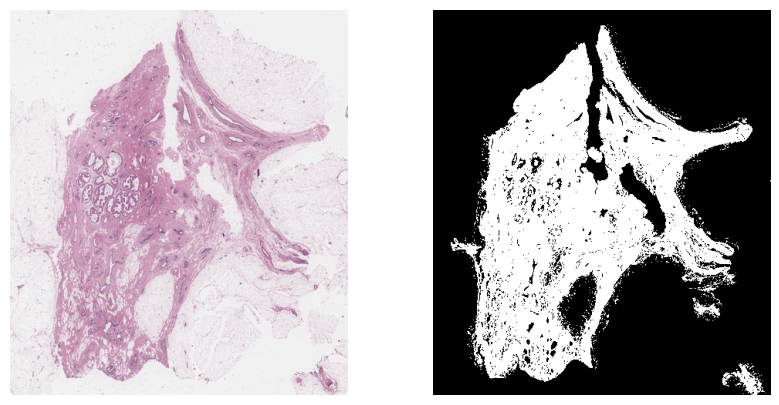

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

thumbnail = slide.get_thumbnail((500, 500))
cthumbnail = clean_thumbnail(thumbnail)
tissue_mask = (cthumbnail.mean(axis=2) != 255)*1.

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tissue_mask, cmap='Greys_r')
plt.axis('off')

In [7]:
objective_power = int(slide.properties.get('openslide.objective-power', 40))
w, h = slide.dimensions

# at 20× it's 1000 px; at 40× it's 2000 px
patch_size = (objective_power/20.)*1000

mask_hratio = (tissue_mask.shape[0]/h)*patch_size
mask_wratio = (tissue_mask.shape[1]/w)*patch_size

patches = []
for i, hi in enumerate(range(0, h, int(patch_size))):
    _patches = []
    for j, wi in enumerate(range(0, w, int(patch_size))):
        mi = int(i*mask_hratio)
        mj = int(j*mask_wratio)
        patch_mask = tissue_mask[mi:mi+int(mask_hratio), mj:mj+int(mask_wratio)]
        tissue_coverage = np.count_nonzero(patch_mask)/max(1, patch_mask.size)
        _patches.append({'loc': [i, j], 'wsi_loc': [int(hi), int(wi)], 'tissue_coverage': tissue_coverage})
    patches.append(_patches)

In [8]:
TARGET_MPP = 0.5
OUT_PX     = 256
FOV_UM     = TARGET_MPP * OUT_PX        # 128 µm

READ_LEVEL = 0                          # for 40× (typical downsamples [1,4,16,...])
base_mpp   = float(slide.properties.get('openslide.mpp-x', 10.0 / objective_power))
dsL        = float(slide.level_downsamples[READ_LEVEL])   # ~1.0 at L0
eff_mpp    = base_mpp * dsL                                # µm/px at READ_LEVEL (~0.25 for 40×@L0)
N_read     = int(round(FOV_UM / eff_mpp))                  # pixels to read so FOV≈128 µm (≈512)
coord_scale = eff_mpp / TARGET_MPP                         # map READ_LEVEL px → 0.5-MPP px (≈0.5)
W0, H0     = slide.dimensions

In [10]:
import numpy as np
import tqdm
from sklearn.cluster import KMeans
from PIL import Image
tissue_threshold = 0.7

flat_patches = np.ravel(patches)
for patch in tqdm.tqdm(flat_patches):
    if patch['tissue_coverage'] < tissue_threshold:
        continue

    # Original Yottixel top-left in BASE (level-0) pixels
    h0, w0 = patch['wsi_loc']

    # --- ***ONLY THE READ/RESIZE LINES ARE CHANGED*** ---
    # Clamp to avoid overrun near slide borders
    x_read = max(0, min(w0, W0 - N_read))
    y_read = max(0, min(h0, H0 - N_read))

    # Read a window that physically spans ~128 µm, then resize to 256×256 -> 0.5 MPP
    patch_region = slide.read_region((x_read, y_read), READ_LEVEL, (N_read, N_read)).convert('RGB')
    if patch_region.size[0] != OUT_PX:
        patch_region = patch_region.resize((OUT_PX, OUT_PX), Image.BILINEAR)

    # Optional: store 0.5-MPP top-left coords for later slide-encoder use
    patch['coord_05'] = [int(round(x_read * coord_scale)), int(round(y_read * coord_scale))]

    # Same RGB summary feature as your code (mean RGB)
    arr = (np.array(patch_region)/255.).reshape((OUT_PX*OUT_PX, 3))
    histogram = arr.mean(axis=0)
    patch['rgb_histogram'] = histogram

100%|██████████| 1116/1116 [00:06<00:00, 173.63it/s]


In [11]:
selected_patches_flags = [p.get('tissue_coverage', 0) >= tissue_threshold for p in flat_patches]
selected_patches = flat_patches[selected_patches_flags]

kmeans_clusters = 9
features = np.array([entry['rgb_histogram'] for entry in selected_patches])
kmeans = KMeans(n_clusters=kmeans_clusters, n_init='auto', random_state=0).fit(features)

# Attach labels back
for patch, lbl in zip(selected_patches, kmeans.labels_):
    patch['cluster_lbl'] = int(lbl)

/tmp/ipython-input-1906171281.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', kmeans_clusters)


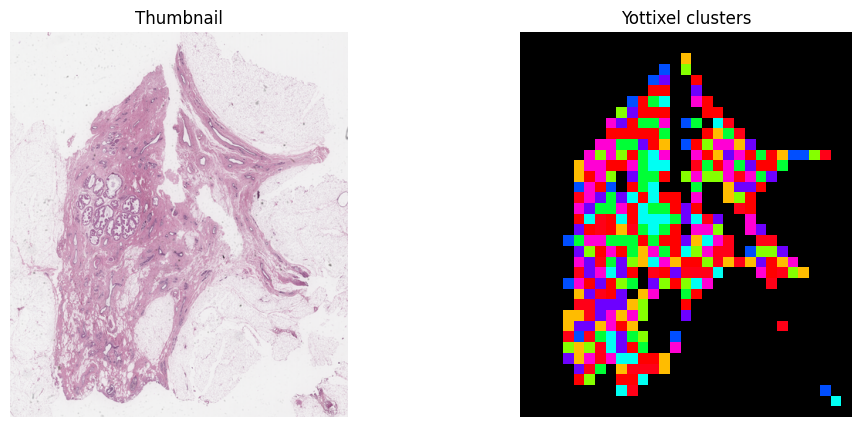

[DBG] READ_LEVEL=0, eff_mpp≈0.252 µm/px, N_read=507, coord_scale=0.505
Selected patches: 351


In [12]:
cmap = plt.cm.get_cmap('hsv', kmeans_clusters)
patch_clusters = np.zeros(np.array(patches).shape + (3,))
for patch in selected_patches:
    i, j = patch['loc']
    lbl = patch['cluster_lbl']
    patch_clusters[i, j, :] = cmap(lbl)[:3]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(thumbnail); plt.axis('off'); plt.title('Thumbnail')
plt.subplot(1, 2, 2); plt.imshow(patch_clusters); plt.axis('off'); plt.title('Yottixel clusters')
plt.show()

print(f"[DBG] READ_LEVEL={READ_LEVEL}, eff_mpp≈{eff_mpp:.3f} µm/px, N_read={N_read}, coord_scale={coord_scale:.3f}")
print(f"Selected patches: {len(selected_patches)}")

In [13]:
percentage_selected = 15

mosaic = []

for i in range(kmeans_clusters):
    cluster_patches = selected_patches[kmeans.labels_ == i]
    n_selected = max(1, int(len(cluster_patches)*percentage_selected/100.))

    km = KMeans(n_clusters=n_selected)
    loc_features = [patch['wsi_loc'] for patch in cluster_patches]
    ds = km.fit_transform(loc_features)

    c_selected_idx = []
    for idx in range(n_selected):
        sorted_idx = np.argsort(ds[:, idx])

        for sidx in sorted_idx:
            if sidx not in c_selected_idx:
                c_selected_idx.append(sidx)
                mosaic.append(cluster_patches[sidx])
                break

(np.float64(-0.5), np.float64(30.5), np.float64(35.5), np.float64(-0.5))

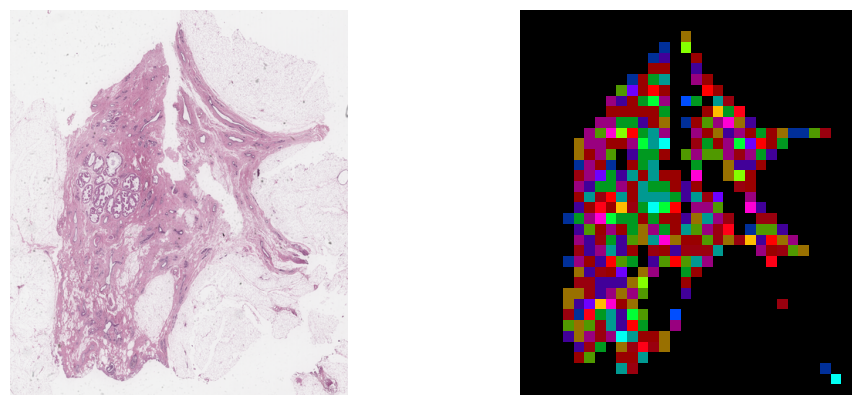

In [14]:
patch_clusters = np.zeros(np.array(patches).shape+(3,))

for patch in selected_patches:
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = np.array(cmap(patch['cluster_lbl'])[:3])*0.6
for patch in mosaic:
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = cmap(patch['cluster_lbl'])[:3]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(patch_clusters)
plt.axis('off')

In [15]:
# gigapath encoder
import os
from pathlib import Path
import torch
import timm
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import subprocess

import os
# insert token
os.environ['HF_TOKEN'] = ''
hf_token = os.getenv("HF_TOKEN")
assert hf_token, "HF_TOKEN is not set"

# Authenticate to access Google Cloud resources
from google.colab import auth
auth.authenticate_user()


import timm
# Load model
tile_encoder = timm.create_model("hf_hub:prov-gigapath/prov-gigapath", pretrained=True).cuda().eval()
print("✅ Tile Encoder loaded.")
print("🧮 Total parameters:", sum(p.numel() for p in tile_encoder.parameters()))

# Image transform
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

✅ Tile Encoder loaded.
🧮 Total parameters: 1134953984


In [19]:
# For the whole split

In [27]:
# ---------- Drive -----------

try:
    from google.colab import drive  # works in Colab
    drive.mount('/content/drive', force_remount=False)
    DRIVE_ROOT = Path('/content/drive/MyDrive')
    assert DRIVE_ROOT.exists(), "Drive mount failed (MyDrive not found)."
except Exception as e:
    raise RuntimeError(
        "Google Drive is not mounted. Run this in Google Colab or mount Drive first."
    ) from e

Mounted at /content/drive


In [39]:
# ================================
# GCS → Mosaic(0.5MPP) → GigaPath Embeddings → Save to Drive (+ thumbnails) → Clean up
# ================================

import os, io, math, gc, cv2, tqdm, numpy as np
from pathlib import Path
from PIL import Image
import torch
from torchvision import transforms
import timm
import openslide
from sklearn.cluster import KMeans

from google.cloud import storage


# ---------- CONFIG ----------
BUCKET_NAME = 'bracs-dataset-bucket'   # <<< set me
SPLIT = "train"                     # "train" | "val" | "test"

PREFIXES = [
    f"BRACS/BRACS_WSI/{SPLIT}/Group_AT/",
    f"BRACS/BRACS_WSI/{SPLIT}/Group_BT/",
    f"BRACS/BRACS_WSI/{SPLIT}/Group_MT/",
]

LOCAL_SLIDES_DIR = Path("/content/slides")                             # local temp store
LOCAL_SLIDES_DIR.mkdir(parents=True, exist_ok=True)

DRIVE_SAVE_DIR   = DRIVE_ROOT / "BRACS" / "Embeddings" / SPLIT
DRIVE_MOSAIC_DIR = DRIVE_ROOT / "BRACS" / "Mosaic"     / SPLIT
DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)
DRIVE_MOSAIC_DIR.mkdir(parents=True, exist_ok=True)

# Mosaic (Yottixel) params
TISSUE_THRESHOLD = 0.7
KMEANS_CLUSTERS  = 9
PERCENTAGE_SELECTED = 15   # per-cluster %

# GigaPath params
TARGET_MPP = 0.5
OUT_PX     = 256
BATCH_SIZE = 20
READ_LEVEL = 0             # good default for 40× pyramids ~[1,4,16,...]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- GCS helpers ----------
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

def list_slides(prefixes):
    slides = []
    for pref in prefixes:
        for b in client.list_blobs(BUCKET_NAME, prefix=pref):
            if b.name.lower().endswith(".svs"):
                slides.append(b.name)
    return slides

def download_slide_to_local(blob_name: str, local_dir: Path) -> Path:
    slide_id = os.path.basename(blob_name)
    local_path = local_dir / slide_id
    if not local_path.exists():
        print(f"Downloading: gs://{BUCKET_NAME}/{blob_name} -> {local_path}")
        bucket.blob(blob_name).download_to_filename(str(local_path))
    else:
        print(f"Exists locally, skipping download: {local_path}")
    return local_path

# ---------- Yottixel utilities ----------
def RGB2HSD(X):
    eps = np.finfo(float).eps
    X[np.where(X==0.0)] = eps
    OD = -np.log(X / 1.0)
    D  = np.mean(OD,3); D[np.where(D==0.0)] = eps
    cx = OD[:,:,:,0] / (D) - 1.0
    cy = (OD[:,:,:,1]-OD[:,:,:,2]) / (np.sqrt(3.0)*D)
    D  = np.expand_dims(D,3); cx = np.expand_dims(cx,3); cy = np.expand_dims(cy,3)
    return np.concatenate((D,cx,cy),3)

def clean_thumbnail(thumbnail):
    thumbnail_arr = np.asarray(thumbnail)
    wthumbnail = np.zeros_like(thumbnail_arr); wthumbnail[:] = thumbnail_arr
    thumbnail_std = np.std(wthumbnail, axis=2)
    wthumbnail[thumbnail_std<5] = (np.ones((1,3), dtype="uint8")*255)
    thumbnail_HSD = RGB2HSD( np.array([wthumbnail.astype('float32')/255.]) )[0]
    kernel = np.ones((30,30),np.float32)/900
    thumbnail_HSD_mean = cv2.filter2D(thumbnail_HSD[:,:,2], -1, kernel)
    wthumbnail[thumbnail_HSD_mean<0.05] = (np.ones((1,3),dtype="uint8")*255)
    return wthumbnail

# ---------- GigaPath transforms & encoder ----------
def load_tile_encoder_transforms() -> transforms.Compose:
    return transforms.Compose([
        transforms.Resize(OUT_PX, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

def load_gigapath_tile_encoder(local_ckpt: str = "") -> torch.nn.Module:
    if local_ckpt:
        m = timm.create_model("hf_hub:prov-gigapath/prov-gigapath",
                              pretrained=False, checkpoint_path=local_ckpt)
    else:
        m = timm.create_model("hf_hub:prov-gigapath/prov-gigapath", pretrained=True)
    m.eval().to(DEVICE)
    return m

GP_TRANSFORM = load_tile_encoder_transforms()
TILE_ENCODER = load_gigapath_tile_encoder()

# ---------- Core: per-slide mosaic at 0.5 MPP (256×256 reads) ----------
def build_mosaic_05mpp(slide: openslide.OpenSlide,
                       tissue_threshold: float = TISSUE_THRESHOLD,
                       kmeans_clusters: int = KMEANS_CLUSTERS,
                       percentage_selected: int = PERCENTAGE_SELECTED,
                       read_level: int = READ_LEVEL):
    W0, H0 = slide.dimensions
    objective_power = int(slide.properties.get('openslide.objective-power', 40))

    # Tissue mask on thumbnail (Yottixel code)
    thumbnail = slide.get_thumbnail((500, 500))
    cthumb = clean_thumbnail(thumbnail)
    tissue_mask = (cthumb.mean(axis=2) != 255)*1.

    # Yottixel patch grid (500 µm → 1000 px@20×, 2000 px@40×)
    patch_size = (objective_power/20.0)*1000.0
    mask_hratio = (tissue_mask.shape[0]/H0)*patch_size
    mask_wratio = (tissue_mask.shape[1]/W0)*patch_size

    patches = []
    for i, hi in enumerate(range(0, H0, int(patch_size))):
        row = []
        for j, wi in enumerate(range(0, W0, int(patch_size))):
            mi = int(i*mask_hratio); mj = int(j*mask_wratio)
            pmask = tissue_mask[mi:mi+int(mask_hratio), mj:mj+int(mask_wratio)]
            coverage = float(np.count_nonzero(pmask))/max(1, pmask.size)
            row.append({'loc':[i,j], 'wsi_loc':[int(hi),int(wi)], 'tissue_coverage':coverage})
        patches.append(row)

    # Geometry for exact 0.5 MPP read
    base_mpp = float(slide.properties.get('openslide.mpp-x', 10.0/objective_power))
    dsL = float(slide.level_downsamples[read_level])  # ~1.0 at L0 for 40×
    eff_mpp = base_mpp * dsL
    FOV_UM = TARGET_MPP * OUT_PX  # 128 µm
    N_read = int(round(FOV_UM / eff_mpp))
    coord_scale = eff_mpp / TARGET_MPP

    flat = np.ravel(np.array(patches, dtype=object))
    feats, idx_keep = [], []

    # Read 0.5MPP 256×256 for RGB feature
    for idx, p in enumerate(flat):
        if p['tissue_coverage'] < TISSUE_THRESHOLD:
            continue
        y0, x0 = p['wsi_loc']  # top-left in base pixels
        xr = max(0, min(x0, W0 - N_read))
        yr = max(0, min(y0, H0 - N_read))

        region = slide.read_region((xr, yr), read_level, (N_read, N_read)).convert("RGB")
        if region.size[0] != OUT_PX:
            region = region.resize((OUT_PX, OUT_PX), Image.BILINEAR)

        arr = (np.array(region)/255.).reshape((OUT_PX*OUT_PX, 3))
        hist = arr.mean(axis=0)
        p['rgb_histogram'] = hist
        p['coord_05'] = [int(round(xr*coord_scale)), int(round(yr*coord_scale))]
        p['x_read'] = int(xr); p['y_read'] = int(yr); p['N_read'] = int(N_read); p['read_level'] = int(read_level)

        feats.append(hist); idx_keep.append(idx)

    if not feats:
        return []

    feats = np.array(feats, dtype=np.float32)
    sel = flat[np.array(idx_keep, dtype=int)]

    # Cluster by color (unchanged Yottixel)
    kmeans = KMeans(n_clusters=kmeans_clusters, n_init='auto', random_state=0).fit(feats)
    for p, lbl in zip(sel, kmeans.labels_):
        p['cluster_lbl'] = int(lbl)

    # Mosaic selection by spatial KMeans per cluster (your logic)
    mosaic = []
    for c in range(kmeans_clusters):
        mask = (kmeans.labels_ == c)
        Cp = sel[mask]
        if len(Cp) == 0:
            continue
        n_sel = max(1, int(len(Cp)*percentage_selected/100.0))
        n_sel = min(n_sel, len(Cp))

        loc_features = [p['wsi_loc'] for p in Cp]
        km = KMeans(n_clusters=n_sel, n_init='auto', random_state=0)
        ds = km.fit_transform(loc_features)

        chosen = []
        for col in range(n_sel):
            for sidx in np.argsort(ds[:, col]):
                if sidx not in chosen:
                    chosen.append(sidx)
                    mosaic.append(Cp[sidx])
                    break

    return mosaic

# ---------- Encode mosaic with Prov-GigaPath tile encoder ----------
def encode_mosaic_with_gigapath(slide: openslide.OpenSlide, mosaic: list,
                                batch_size: int = BATCH_SIZE) -> torch.Tensor:
    if not mosaic:
        return torch.empty(0, 0)

    imgs = []
    for p in mosaic:
        xr, yr, N, rl = p['x_read'], p['y_read'], p['N_read'], p['read_level']
        region = slide.read_region((xr, yr), rl, (N, N)).convert("RGB")
        imgs.append(GP_TRANSFORM(region))   # Resize256 → CenterCrop224 → Normalize

    X = torch.stack(imgs, 0).to(DEVICE)
    TILE_ENCODER.eval()

    outs = []
    with torch.no_grad():
        for i in range(0, X.size(0), batch_size):
            batch = X[i:i+batch_size]
            out = TILE_ENCODER(batch)          # [B, D]
            outs.append(out.detach().cpu())
    E = torch.cat(outs, 0)                     # [N, D]

    for i, emb in enumerate(E):
        mosaic[i]['gigapath_embedding'] = emb.numpy()

    # free activations ASAP
    del X, outs, batch, out
    if DEVICE.type == "cuda":
        torch.cuda.empty_cache()

    return E

# ---------- Save thumbnails of the mosaic (256×256 at 0.5 MPP) ----------
def save_mosaic_thumbnails(slide_blob_name: str, slide: openslide.OpenSlide, mosaic: list):
    """
    Saves each selected tile as a 256×256 PNG (0.5 MPP) to
    BRACS/Mosaic/{split}/{slide_id}/NNNN_xX_yY_cC.png
    """
    if not mosaic:
        return
    slide_id = os.path.basename(slide_blob_name).split('.')[0]
    out_dir = DRIVE_MOSAIC_DIR / slide_id
    out_dir.mkdir(parents=True, exist_ok=True)

    for idx, p in enumerate(mosaic):
        xr, yr, N, rl = p['x_read'], p['y_read'], p['N_read'], p['read_level']
        img = slide.read_region((xr, yr), rl, (N, N)).convert("RGB")
        if img.size[0] != OUT_PX:
            img = img.resize((OUT_PX, OUT_PX), Image.BILINEAR)
        x05, y05 = p['coord_05']
        c = p.get('cluster_lbl', -1)
        fname = f"{idx:04d}_{x05}x_{y05}y_c{c}.png"
        img.save(out_dir / fname)

# ---------- Save slide embeddings to Drive ----------
def save_slide_embeddings(slide_blob_name: str, embeddings: torch.Tensor, mosaic: list):
    slide_id = os.path.basename(slide_blob_name).split('.')[0]
    out_path = DRIVE_SAVE_DIR / f"{slide_id}.pt"

    coords_05 = torch.tensor([p['coord_05'] for p in mosaic], dtype=torch.float32)
    indices   = [p['loc'] for p in mosaic]
    wsi_locs  = [p['wsi_loc'] for p in mosaic]

    payload = {
        'tile_embeds': embeddings,      # [N, D] CPU tensor
        'coords_05': coords_05,         # [N, 2]
        'indices': indices,
        'wsi_locs': wsi_locs,
    }
    torch.save(payload, out_path)
    print(f"Saved embeddings: {out_path}")

# ---------- End-to-end for one slide (with clean-up) ----------
def process_one_slide(slide_blob_name: str):
    local_path = download_slide_to_local(slide_blob_name, LOCAL_SLIDES_DIR)
    slide = None
    try:
        slide = openslide.OpenSlide(str(local_path))

        # 1) Build mosaic (0.5 MPP, 256 px tiles for RGB & coords)
        mosaic = build_mosaic_05mpp(slide)
        print(f"Mosaic size: {len(mosaic)}")
        if not mosaic:
            return

        # 2) Encode with GigaPath tile encoder
        E = encode_mosaic_with_gigapath(slide, mosaic, batch_size=BATCH_SIZE)
        print(f"Embeddings tensor: {tuple(E.shape)}")

        # 3) Save embeddings and thumbnails to Drive
        save_slide_embeddings(slide_blob_name, E, mosaic)
        # save_mosaic_thumbnails(slide_blob_name, slide, mosaic)

    finally:
        # --- Aggressive clean-up: free memory & disk ---
        try:
            if slide is not None:
                slide.close()
        except Exception as _:
            pass

        # delete local WSI copy to free disk
        try:
            if os.path.exists(local_path):
                os.remove(local_path)
                print(f"Deleted local slide: {local_path}")
        except Exception as e:
            print(f"[WARN] Could not delete {local_path}: {e}")

        # free Python/GPU memory for next slide
        for var in ["mosaic", "E"]:
            if var in locals():
                del locals()[var]
        gc.collect()
        if DEVICE.type == "cuda":
            torch.cuda.empty_cache()


In [40]:
# ---------- Run for the whole split ----------

all_slides = list_slides(PREFIXES)
print(f"Found {len(all_slides)} slides in {SPLIT}.")


for blob_name in tqdm.tqdm(all_slides, desc=f"Processing {SPLIT}"):
    try:
        process_one_slide(blob_name)
    except Exception as e:
        print(f"[ERROR] {blob_name}: {e}")
        continue

Found 395 slides in train.


Processing train:   0%|          | 0/395 [00:00<?, ?it/s]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1003728.svs -> /content/slides/BRACS_1003728.svs
Mosaic size: 0
Deleted local slide: /content/slides/BRACS_1003728.svs


Processing train:   0%|          | 1/395 [00:38<4:14:29, 38.76s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1379.svs -> /content/slides/BRACS_1379.svs
Mosaic size: 0
Deleted local slide: /content/slides/BRACS_1379.svs


Processing train:   1%|          | 2/395 [01:18<4:17:40, 39.34s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1486.svs -> /content/slides/BRACS_1486.svs
Mosaic size: 67
Embeddings tensor: (67, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1486.pt


Processing train:   1%|          | 3/395 [02:27<5:46:36, 53.05s/it]

Deleted local slide: /content/slides/BRACS_1486.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1494.svs -> /content/slides/BRACS_1494.svs
Mosaic size: 58
Embeddings tensor: (58, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1494.pt


Processing train:   1%|          | 4/395 [03:39<6:33:19, 60.36s/it]

Deleted local slide: /content/slides/BRACS_1494.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1499.svs -> /content/slides/BRACS_1499.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1499.pt
Deleted local slide: /content/slides/BRACS_1499.svs


Processing train:   1%|▏         | 5/395 [04:00<5:01:00, 46.31s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1616.svs -> /content/slides/BRACS_1616.svs
Mosaic size: 0
Deleted local slide: /content/slides/BRACS_1616.svs


Processing train:   2%|▏         | 6/395 [04:35<4:34:39, 42.36s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1622.svs -> /content/slides/BRACS_1622.svs
Mosaic size: 36
Embeddings tensor: (36, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1622.pt


Processing train:   2%|▏         | 7/395 [05:32<5:04:58, 47.16s/it]

Deleted local slide: /content/slides/BRACS_1622.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1794.svs -> /content/slides/BRACS_1794.svs
Mosaic size: 121
Embeddings tensor: (121, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1794.pt


Processing train:   2%|▏         | 8/395 [06:55<6:16:53, 58.43s/it]

Deleted local slide: /content/slides/BRACS_1794.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1795.svs -> /content/slides/BRACS_1795.svs
Mosaic size: 106
Embeddings tensor: (106, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1795.pt


Processing train:   2%|▏         | 9/395 [08:09<6:48:27, 63.49s/it]

Deleted local slide: /content/slides/BRACS_1795.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1808.svs -> /content/slides/BRACS_1808.svs
Mosaic size: 108
Embeddings tensor: (108, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1808.pt


Processing train:   3%|▎         | 10/395 [09:32<7:24:42, 69.30s/it]

Deleted local slide: /content/slides/BRACS_1808.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1860.svs -> /content/slides/BRACS_1860.svs
Mosaic size: 96
Embeddings tensor: (96, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1860.pt


Processing train:   3%|▎         | 11/395 [10:52<7:45:44, 72.77s/it]

Deleted local slide: /content/slides/BRACS_1860.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1861.svs -> /content/slides/BRACS_1861.svs
Mosaic size: 131
Embeddings tensor: (131, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1861.pt


Processing train:   3%|▎         | 12/395 [12:31<8:34:38, 80.62s/it]

Deleted local slide: /content/slides/BRACS_1861.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1863.svs -> /content/slides/BRACS_1863.svs
Mosaic size: 132
Embeddings tensor: (132, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1863.pt


Processing train:   3%|▎         | 13/395 [14:11<9:11:37, 86.64s/it]

Deleted local slide: /content/slides/BRACS_1863.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1877.svs -> /content/slides/BRACS_1877.svs
Mosaic size: 73
Embeddings tensor: (73, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1877.pt
Deleted local slide: /content/slides/BRACS_1877.svs


Processing train:   4%|▎         | 14/395 [15:08<8:12:31, 77.56s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1882.svs -> /content/slides/BRACS_1882.svs
Mosaic size: 33
Embeddings tensor: (33, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1882.pt
Deleted local slide: /content/slides/BRACS_1882.svs


Processing train:   4%|▍         | 15/395 [15:41<6:45:42, 64.06s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1899.svs -> /content/slides/BRACS_1899.svs
Mosaic size: 104
Embeddings tensor: (104, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1899.pt


Processing train:   4%|▍         | 16/395 [16:56<7:06:30, 67.52s/it]

Deleted local slide: /content/slides/BRACS_1899.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1911.svs -> /content/slides/BRACS_1911.svs
Mosaic size: 37
Embeddings tensor: (37, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1911.pt
Deleted local slide: /content/slides/BRACS_1911.svs


Processing train:   4%|▍         | 17/395 [17:39<6:18:31, 60.08s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1912.svs -> /content/slides/BRACS_1912.svs
Mosaic size: 54
Embeddings tensor: (54, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1912.pt


Processing train:   5%|▍         | 18/395 [18:38<6:14:49, 59.66s/it]

Deleted local slide: /content/slides/BRACS_1912.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1913.svs -> /content/slides/BRACS_1913.svs
Mosaic size: 130
Embeddings tensor: (130, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1913.pt


Processing train:   5%|▍         | 19/395 [20:14<7:23:15, 70.73s/it]

Deleted local slide: /content/slides/BRACS_1913.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1915.svs -> /content/slides/BRACS_1915.svs
Mosaic size: 112
Embeddings tensor: (112, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1915.pt


Processing train:   5%|▌         | 20/395 [21:47<8:04:04, 77.45s/it]

Deleted local slide: /content/slides/BRACS_1915.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1922.svs -> /content/slides/BRACS_1922.svs
Mosaic size: 103
Embeddings tensor: (103, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1922.pt


Processing train:   5%|▌         | 21/395 [23:21<8:33:15, 82.34s/it]

Deleted local slide: /content/slides/BRACS_1922.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1925.svs -> /content/slides/BRACS_1925.svs
Mosaic size: 64
Embeddings tensor: (64, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1925.pt


Processing train:   6%|▌         | 22/395 [24:25<7:58:30, 76.97s/it]

Deleted local slide: /content/slides/BRACS_1925.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1932.svs -> /content/slides/BRACS_1932.svs
Mosaic size: 48
Embeddings tensor: (48, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1932.pt


Processing train:   6%|▌         | 23/395 [25:26<7:25:51, 71.91s/it]

Deleted local slide: /content/slides/BRACS_1932.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1933.svs -> /content/slides/BRACS_1933.svs
Mosaic size: 108
Embeddings tensor: (108, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1933.pt


Processing train:   6%|▌         | 24/395 [27:08<8:21:15, 81.07s/it]

Deleted local slide: /content/slides/BRACS_1933.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1934.svs -> /content/slides/BRACS_1934.svs
Mosaic size: 82
Embeddings tensor: (82, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1934.pt


Processing train:   6%|▋         | 25/395 [28:26<8:14:59, 80.27s/it]

Deleted local slide: /content/slides/BRACS_1934.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1969.svs -> /content/slides/BRACS_1969.svs
Mosaic size: 92
Embeddings tensor: (92, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1969.pt


Processing train:   7%|▋         | 26/395 [29:38<7:58:19, 77.78s/it]

Deleted local slide: /content/slides/BRACS_1969.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1987.svs -> /content/slides/BRACS_1987.svs
Mosaic size: 117
Embeddings tensor: (117, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1987.pt


Processing train:   7%|▋         | 27/395 [30:54<7:53:26, 77.19s/it]

Deleted local slide: /content/slides/BRACS_1987.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_3318.svs -> /content/slides/BRACS_3318.svs
Mosaic size: 51
Embeddings tensor: (51, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3318.pt


Processing train:   7%|▋         | 28/395 [31:47<7:07:06, 69.83s/it]

Deleted local slide: /content/slides/BRACS_3318.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1003693.svs -> /content/slides/BRACS_1003693.svs
Mosaic size: 105
Embeddings tensor: (105, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003693.pt


Processing train:   7%|▋         | 29/395 [33:24<7:56:23, 78.10s/it]

Deleted local slide: /content/slides/BRACS_1003693.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1239.svs -> /content/slides/BRACS_1239.svs
Mosaic size: 201
Embeddings tensor: (201, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1239.pt


Processing train:   8%|▊         | 30/395 [35:54<10:06:02, 99.62s/it]

Deleted local slide: /content/slides/BRACS_1239.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1250.svs -> /content/slides/BRACS_1250.svs
Mosaic size: 106
Embeddings tensor: (106, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1250.pt


Processing train:   8%|▊         | 31/395 [37:13<9:27:01, 93.47s/it] 

Deleted local slide: /content/slides/BRACS_1250.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1257.svs -> /content/slides/BRACS_1257.svs
Mosaic size: 224
Embeddings tensor: (224, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1257.pt


Processing train:   8%|▊         | 32/395 [39:42<11:05:20, 109.97s/it]

Deleted local slide: /content/slides/BRACS_1257.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1319.svs -> /content/slides/BRACS_1319.svs
Mosaic size: 115
Embeddings tensor: (115, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1319.pt


Processing train:   8%|▊         | 33/395 [41:07<10:19:34, 102.69s/it]

Deleted local slide: /content/slides/BRACS_1319.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1506.svs -> /content/slides/BRACS_1506.svs
Mosaic size: 62
Embeddings tensor: (62, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1506.pt


Processing train:   9%|▊         | 34/395 [42:07<9:00:06, 89.77s/it]  

Deleted local slide: /content/slides/BRACS_1506.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1510.svs -> /content/slides/BRACS_1510.svs
Mosaic size: 40
Embeddings tensor: (40, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1510.pt


Processing train:   9%|▉         | 35/395 [42:57<7:46:25, 77.74s/it]

Deleted local slide: /content/slides/BRACS_1510.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1773.svs -> /content/slides/BRACS_1773.svs
Mosaic size: 115
Embeddings tensor: (115, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1773.pt


Processing train:   9%|▉         | 36/395 [44:19<7:53:51, 79.20s/it]

Deleted local slide: /content/slides/BRACS_1773.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1774.svs -> /content/slides/BRACS_1774.svs
Mosaic size: 44
Embeddings tensor: (44, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1774.pt
Deleted local slide: /content/slides/BRACS_1774.svs


Processing train:   9%|▉         | 37/395 [44:52<6:29:59, 65.36s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1775.svs -> /content/slides/BRACS_1775.svs
Mosaic size: 87
Embeddings tensor: (87, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1775.pt


Processing train:  10%|▉         | 38/395 [45:59<6:31:05, 65.73s/it]

Deleted local slide: /content/slides/BRACS_1775.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1777.svs -> /content/slides/BRACS_1777.svs
Mosaic size: 157
Embeddings tensor: (157, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1777.pt


Processing train:  10%|▉         | 39/395 [47:44<7:39:36, 77.46s/it]

Deleted local slide: /content/slides/BRACS_1777.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1778.svs -> /content/slides/BRACS_1778.svs
Mosaic size: 46
Embeddings tensor: (46, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1778.pt
Deleted local slide: /content/slides/BRACS_1778.svs


Processing train:  10%|█         | 40/395 [48:23<6:30:56, 66.07s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1788.svs -> /content/slides/BRACS_1788.svs
Mosaic size: 52
Embeddings tensor: (52, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1788.pt
Deleted local slide: /content/slides/BRACS_1788.svs


Processing train:  10%|█         | 41/395 [49:15<6:04:06, 61.71s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1815.svs -> /content/slides/BRACS_1815.svs
Mosaic size: 111
Embeddings tensor: (111, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1815.pt


Processing train:  11%|█         | 42/395 [50:45<6:52:33, 70.12s/it]

Deleted local slide: /content/slides/BRACS_1815.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1838.svs -> /content/slides/BRACS_1838.svs
Mosaic size: 118
Embeddings tensor: (118, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1838.pt


Processing train:  11%|█         | 43/395 [52:18<7:32:08, 77.07s/it]

Deleted local slide: /content/slides/BRACS_1838.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1857.svs -> /content/slides/BRACS_1857.svs
Mosaic size: 56
Embeddings tensor: (56, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1857.pt


Processing train:  11%|█         | 44/395 [53:14<6:53:31, 70.69s/it]

Deleted local slide: /content/slides/BRACS_1857.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1858.svs -> /content/slides/BRACS_1858.svs
Mosaic size: 204
Embeddings tensor: (204, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1858.pt


Processing train:  11%|█▏        | 45/395 [55:24<8:37:00, 88.63s/it]

Deleted local slide: /content/slides/BRACS_1858.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1865.svs -> /content/slides/BRACS_1865.svs
Mosaic size: 152
Embeddings tensor: (152, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1865.pt


Processing train:  12%|█▏        | 46/395 [57:01<8:50:27, 91.20s/it]

Deleted local slide: /content/slides/BRACS_1865.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1871.svs -> /content/slides/BRACS_1871.svs
Mosaic size: 82
Embeddings tensor: (82, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1871.pt


Processing train:  12%|█▏        | 47/395 [58:01<7:53:39, 81.67s/it]

Deleted local slide: /content/slides/BRACS_1871.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1916.svs -> /content/slides/BRACS_1916.svs
Mosaic size: 54
Embeddings tensor: (54, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1916.pt


Processing train:  12%|█▏        | 48/395 [58:54<7:02:15, 73.01s/it]

Deleted local slide: /content/slides/BRACS_1916.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1926.svs -> /content/slides/BRACS_1926.svs
Mosaic size: 84
Embeddings tensor: (84, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1926.pt


Processing train:  12%|█▏        | 49/395 [59:59<6:48:07, 70.77s/it]

Deleted local slide: /content/slides/BRACS_1926.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1968.svs -> /content/slides/BRACS_1968.svs
Mosaic size: 74
Embeddings tensor: (74, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1968.pt


Processing train:  13%|█▎        | 50/395 [1:00:59<6:27:24, 67.37s/it]

Deleted local slide: /content/slides/BRACS_1968.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_1971.svs -> /content/slides/BRACS_1971.svs
Mosaic size: 86
Embeddings tensor: (86, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1971.pt


Processing train:  13%|█▎        | 51/395 [1:02:03<6:21:02, 66.46s/it]

Deleted local slide: /content/slides/BRACS_1971.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_AT/Type_FEA/BRACS_743.svs -> /content/slides/BRACS_743.svs
Mosaic size: 238
Embeddings tensor: (238, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_743.pt


Processing train:  13%|█▎        | 52/395 [1:04:39<8:53:21, 93.30s/it]

Deleted local slide: /content/slides/BRACS_743.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1003675.svs -> /content/slides/BRACS_1003675.svs


Processing train:  13%|█▎        | 53/395 [1:04:59<6:46:03, 71.24s/it]

Deleted local slide: /content/slides/BRACS_1003675.svs
[ERROR] BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1003675.svs: n_samples=1 should be >= n_clusters=9.
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1003713.svs -> /content/slides/BRACS_1003713.svs
Mosaic size: 0
Deleted local slide: /content/slides/BRACS_1003713.svs


Processing train:  14%|█▎        | 54/395 [1:05:11<5:03:46, 53.45s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1003714.svs -> /content/slides/BRACS_1003714.svs


Processing train:  14%|█▍        | 55/395 [1:05:16<3:41:00, 39.00s/it]

Deleted local slide: /content/slides/BRACS_1003714.svs
[ERROR] BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1003714.svs: n_samples=2 should be >= n_clusters=9.
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1003715.svs -> /content/slides/BRACS_1003715.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003715.pt
Deleted local slide: /content/slides/BRACS_1003715.svs


Processing train:  14%|█▍        | 56/395 [1:05:54<3:39:09, 38.79s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1003716.svs -> /content/slides/BRACS_1003716.svs
Mosaic size: 26
Embeddings tensor: (26, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003716.pt
Deleted local slide: /content/slides/BRACS_1003716.svs


Processing train:  14%|█▍        | 57/395 [1:06:41<3:52:41, 41.31s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1003717.svs -> /content/slides/BRACS_1003717.svs
Mosaic size: 0
Deleted local slide: /content/slides/BRACS_1003717.svs


Processing train:  15%|█▍        | 58/395 [1:06:49<2:55:47, 31.30s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1003718.svs -> /content/slides/BRACS_1003718.svs
Mosaic size: 0
Deleted local slide: /content/slides/BRACS_1003718.svs


Processing train:  15%|█▍        | 59/395 [1:06:53<2:08:50, 23.01s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1267.svs -> /content/slides/BRACS_1267.svs
Mosaic size: 45
Embeddings tensor: (45, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1267.pt


Processing train:  15%|█▌        | 60/395 [1:08:08<3:36:09, 38.71s/it]

Deleted local slide: /content/slides/BRACS_1267.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1269.svs -> /content/slides/BRACS_1269.svs
Mosaic size: 72
Embeddings tensor: (72, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1269.pt


Processing train:  15%|█▌        | 61/395 [1:09:19<4:29:24, 48.40s/it]

Deleted local slide: /content/slides/BRACS_1269.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1378.svs -> /content/slides/BRACS_1378.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1378.pt
Deleted local slide: /content/slides/BRACS_1378.svs


Processing train:  16%|█▌        | 62/395 [1:09:57<4:11:08, 45.25s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1385.svs -> /content/slides/BRACS_1385.svs
Mosaic size: 0
Deleted local slide: /content/slides/BRACS_1385.svs


Processing train:  16%|█▌        | 63/395 [1:10:35<3:57:35, 42.94s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1386.svs -> /content/slides/BRACS_1386.svs
Mosaic size: 145
Embeddings tensor: (145, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1386.pt


Processing train:  16%|█▌        | 64/395 [1:12:28<5:53:48, 64.14s/it]

Deleted local slide: /content/slides/BRACS_1386.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1401.svs -> /content/slides/BRACS_1401.svs


Processing train:  16%|█▋        | 65/395 [1:13:09<5:13:30, 57.00s/it]

Deleted local slide: /content/slides/BRACS_1401.svs
[ERROR] BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1401.svs: n_samples=2 should be >= n_clusters=9.
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1403.svs -> /content/slides/BRACS_1403.svs
Mosaic size: 0


Processing train:  17%|█▋        | 66/395 [1:14:00<5:02:32, 55.18s/it]

Deleted local slide: /content/slides/BRACS_1403.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1404.svs -> /content/slides/BRACS_1404.svs
Mosaic size: 0


Processing train:  17%|█▋        | 67/395 [1:14:39<4:36:21, 50.55s/it]

Deleted local slide: /content/slides/BRACS_1404.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1405.svs -> /content/slides/BRACS_1405.svs
Mosaic size: 0
Deleted local slide: /content/slides/BRACS_1405.svs


Processing train:  17%|█▋        | 68/395 [1:15:14<4:09:16, 45.74s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1507.svs -> /content/slides/BRACS_1507.svs
Mosaic size: 51
Embeddings tensor: (51, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1507.pt


Processing train:  17%|█▋        | 69/395 [1:16:12<4:29:30, 49.60s/it]

Deleted local slide: /content/slides/BRACS_1507.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1513.svs -> /content/slides/BRACS_1513.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1513.pt
Deleted local slide: /content/slides/BRACS_1513.svs


Processing train:  18%|█▊        | 70/395 [1:16:41<3:54:14, 43.24s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1641.svs -> /content/slides/BRACS_1641.svs
Mosaic size: 10
Embeddings tensor: (10, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1641.pt
Deleted local slide: /content/slides/BRACS_1641.svs


Processing train:  18%|█▊        | 71/395 [1:17:07<3:25:19, 38.02s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1645.svs -> /content/slides/BRACS_1645.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1645.pt
Deleted local slide: /content/slides/BRACS_1645.svs


Processing train:  18%|█▊        | 72/395 [1:17:31<3:02:58, 33.99s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1658.svs -> /content/slides/BRACS_1658.svs
Mosaic size: 40
Embeddings tensor: (40, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1658.pt
Deleted local slide: /content/slides/BRACS_1658.svs


Processing train:  18%|█▊        | 73/395 [1:18:11<3:11:38, 35.71s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1973.svs -> /content/slides/BRACS_1973.svs
Mosaic size: 63
Embeddings tensor: (63, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1973.pt


Processing train:  19%|█▊        | 74/395 [1:19:23<4:09:34, 46.65s/it]

Deleted local slide: /content/slides/BRACS_1973.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_1998.svs -> /content/slides/BRACS_1998.svs
Mosaic size: 150
Embeddings tensor: (150, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1998.pt


Processing train:  19%|█▉        | 75/395 [1:20:59<5:28:01, 61.50s/it]

Deleted local slide: /content/slides/BRACS_1998.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_3275.svs -> /content/slides/BRACS_3275.svs
Mosaic size: 84
Embeddings tensor: (84, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3275.pt


Processing train:  19%|█▉        | 76/395 [1:22:16<5:51:42, 66.15s/it]

Deleted local slide: /content/slides/BRACS_3275.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_3277.svs -> /content/slides/BRACS_3277.svs
Mosaic size: 15
Embeddings tensor: (15, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3277.pt


Processing train:  19%|█▉        | 77/395 [1:22:58<5:12:00, 58.87s/it]

Deleted local slide: /content/slides/BRACS_3277.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_3282.svs -> /content/slides/BRACS_3282.svs
Mosaic size: 18
Embeddings tensor: (18, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3282.pt


Processing train:  20%|█▉        | 78/395 [1:23:42<4:47:33, 54.43s/it]

Deleted local slide: /content/slides/BRACS_3282.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_N/BRACS_3292.svs -> /content/slides/BRACS_3292.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3292.pt
Deleted local slide: /content/slides/BRACS_3292.svs


Processing train:  20%|██        | 79/395 [1:24:10<4:05:09, 46.55s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003658.svs -> /content/slides/BRACS_1003658.svs
Mosaic size: 104
Embeddings tensor: (104, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003658.pt


Processing train:  20%|██        | 80/395 [1:25:35<5:04:21, 57.97s/it]

Deleted local slide: /content/slides/BRACS_1003658.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003659.svs -> /content/slides/BRACS_1003659.svs
Mosaic size: 63
Embeddings tensor: (63, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003659.pt


Processing train:  21%|██        | 81/395 [1:26:35<5:06:07, 58.49s/it]

Deleted local slide: /content/slides/BRACS_1003659.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003668.svs -> /content/slides/BRACS_1003668.svs
Mosaic size: 0
Deleted local slide: /content/slides/BRACS_1003668.svs


Processing train:  21%|██        | 82/395 [1:27:03<4:18:00, 49.46s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003669.svs -> /content/slides/BRACS_1003669.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003669.pt
Deleted local slide: /content/slides/BRACS_1003669.svs


Processing train:  21%|██        | 83/395 [1:27:39<3:56:05, 45.40s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003671.svs -> /content/slides/BRACS_1003671.svs
Mosaic size: 58
Embeddings tensor: (58, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003671.pt
Deleted local slide: /content/slides/BRACS_1003671.svs


Processing train:  21%|██▏       | 84/395 [1:28:22<3:50:47, 44.53s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003672.svs -> /content/slides/BRACS_1003672.svs
Mosaic size: 83
Embeddings tensor: (83, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003672.pt


Processing train:  22%|██▏       | 85/395 [1:29:28<4:23:37, 51.02s/it]

Deleted local slide: /content/slides/BRACS_1003672.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003686.svs -> /content/slides/BRACS_1003686.svs
Mosaic size: 149
Embeddings tensor: (149, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003686.pt


Processing train:  22%|██▏       | 86/395 [1:31:09<5:40:36, 66.14s/it]

Deleted local slide: /content/slides/BRACS_1003686.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003700.svs -> /content/slides/BRACS_1003700.svs
Mosaic size: 68
Embeddings tensor: (68, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003700.pt


Processing train:  22%|██▏       | 87/395 [1:32:17<5:41:36, 66.55s/it]

Deleted local slide: /content/slides/BRACS_1003700.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003706.svs -> /content/slides/BRACS_1003706.svs
Mosaic size: 21
Embeddings tensor: (21, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003706.pt
Deleted local slide: /content/slides/BRACS_1003706.svs


Processing train:  22%|██▏       | 88/395 [1:32:40<4:33:56, 53.54s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003710.svs -> /content/slides/BRACS_1003710.svs
Mosaic size: 167
Embeddings tensor: (167, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003710.pt


Processing train:  23%|██▎       | 89/395 [1:34:18<5:41:28, 66.96s/it]

Deleted local slide: /content/slides/BRACS_1003710.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003724.svs -> /content/slides/BRACS_1003724.svs
Mosaic size: 163
Embeddings tensor: (163, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003724.pt


Processing train:  23%|██▎       | 90/395 [1:36:08<6:45:41, 79.81s/it]

Deleted local slide: /content/slides/BRACS_1003724.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003725.svs -> /content/slides/BRACS_1003725.svs
Mosaic size: 24
Embeddings tensor: (24, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003725.pt
Deleted local slide: /content/slides/BRACS_1003725.svs


Processing train:  23%|██▎       | 91/395 [1:36:38<5:29:04, 64.95s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003730.svs -> /content/slides/BRACS_1003730.svs
Mosaic size: 85
Embeddings tensor: (85, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003730.pt


Processing train:  23%|██▎       | 92/395 [1:37:39<5:22:27, 63.85s/it]

Deleted local slide: /content/slides/BRACS_1003730.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1003734.svs -> /content/slides/BRACS_1003734.svs
Mosaic size: 12
Embeddings tensor: (12, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003734.pt
Deleted local slide: /content/slides/BRACS_1003734.svs


Processing train:  24%|██▎       | 93/395 [1:38:16<4:39:22, 55.50s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1240.svs -> /content/slides/BRACS_1240.svs
Mosaic size: 207
Embeddings tensor: (207, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1240.pt


Processing train:  24%|██▍       | 94/395 [1:40:43<6:56:25, 83.01s/it]

Deleted local slide: /content/slides/BRACS_1240.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1241.svs -> /content/slides/BRACS_1241.svs
Mosaic size: 209
Embeddings tensor: (209, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1241.pt


Processing train:  24%|██▍       | 95/395 [1:43:17<8:41:46, 104.35s/it]

Deleted local slide: /content/slides/BRACS_1241.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1242.svs -> /content/slides/BRACS_1242.svs
Mosaic size: 186
Embeddings tensor: (186, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1242.pt


Processing train:  24%|██▍       | 96/395 [1:45:32<9:25:55, 113.56s/it]

Deleted local slide: /content/slides/BRACS_1242.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1248.svs -> /content/slides/BRACS_1248.svs
Mosaic size: 32
Embeddings tensor: (32, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1248.pt
Deleted local slide: /content/slides/BRACS_1248.svs


Processing train:  25%|██▍       | 97/395 [1:46:16<7:40:41, 92.76s/it] 

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1249.svs -> /content/slides/BRACS_1249.svs
Mosaic size: 38
Embeddings tensor: (38, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1249.pt


Processing train:  25%|██▍       | 98/395 [1:47:19<6:55:18, 83.90s/it]

Deleted local slide: /content/slides/BRACS_1249.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1251.svs -> /content/slides/BRACS_1251.svs
Mosaic size: 148
Embeddings tensor: (148, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1251.pt


Processing train:  25%|██▌       | 99/395 [1:49:13<7:38:25, 92.92s/it]

Deleted local slide: /content/slides/BRACS_1251.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1253.svs -> /content/slides/BRACS_1253.svs
Mosaic size: 110
Embeddings tensor: (110, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1253.pt


Processing train:  25%|██▌       | 100/395 [1:50:29<7:12:07, 87.89s/it]

Deleted local slide: /content/slides/BRACS_1253.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1255.svs -> /content/slides/BRACS_1255.svs
Mosaic size: 171
Embeddings tensor: (171, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1255.pt


Processing train:  26%|██▌       | 101/395 [1:52:35<8:06:27, 99.28s/it]

Deleted local slide: /content/slides/BRACS_1255.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1259.svs -> /content/slides/BRACS_1259.svs
Mosaic size: 220
Embeddings tensor: (220, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1259.pt


Processing train:  26%|██▌       | 102/395 [1:54:59<9:09:58, 112.62s/it]

Deleted local slide: /content/slides/BRACS_1259.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1273.svs -> /content/slides/BRACS_1273.svs
Mosaic size: 19
Embeddings tensor: (19, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1273.pt
Deleted local slide: /content/slides/BRACS_1273.svs


Processing train:  26%|██▌       | 103/395 [1:55:28<7:05:33, 87.44s/it] 

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1274.svs -> /content/slides/BRACS_1274.svs
Mosaic size: 46
Embeddings tensor: (46, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1274.pt
Deleted local slide: /content/slides/BRACS_1274.svs


Processing train:  26%|██▋       | 104/395 [1:56:10<5:57:45, 73.76s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1318.svs -> /content/slides/BRACS_1318.svs
Mosaic size: 163
Embeddings tensor: (163, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1318.pt


Processing train:  27%|██▋       | 105/395 [1:57:58<6:46:03, 84.01s/it]

Deleted local slide: /content/slides/BRACS_1318.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1320.svs -> /content/slides/BRACS_1320.svs
Mosaic size: 167
Embeddings tensor: (167, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1320.pt


Processing train:  27%|██▋       | 106/395 [2:00:01<7:42:15, 95.97s/it]

Deleted local slide: /content/slides/BRACS_1320.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1321.svs -> /content/slides/BRACS_1321.svs
Mosaic size: 150
Embeddings tensor: (150, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1321.pt


Processing train:  27%|██▋       | 107/395 [2:01:34<7:36:10, 95.03s/it]

Deleted local slide: /content/slides/BRACS_1321.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1322.svs -> /content/slides/BRACS_1322.svs
Mosaic size: 180
Embeddings tensor: (180, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1322.pt


Processing train:  27%|██▋       | 108/395 [2:03:28<8:01:22, 100.64s/it]

Deleted local slide: /content/slides/BRACS_1322.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1324.svs -> /content/slides/BRACS_1324.svs
Mosaic size: 169
Embeddings tensor: (169, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1324.pt


Processing train:  28%|██▊       | 109/395 [2:05:12<8:04:44, 101.69s/it]

Deleted local slide: /content/slides/BRACS_1324.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1325.svs -> /content/slides/BRACS_1325.svs
Mosaic size: 52
Embeddings tensor: (52, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1325.pt


Processing train:  28%|██▊       | 110/395 [2:06:30<7:29:43, 94.68s/it] 

Deleted local slide: /content/slides/BRACS_1325.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1327.svs -> /content/slides/BRACS_1327.svs
Mosaic size: 45
Embeddings tensor: (45, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1327.pt


Processing train:  28%|██▊       | 111/395 [2:07:43<6:56:28, 87.99s/it]

Deleted local slide: /content/slides/BRACS_1327.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1329.svs -> /content/slides/BRACS_1329.svs
Mosaic size: 138
Embeddings tensor: (138, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1329.pt


Processing train:  28%|██▊       | 112/395 [2:09:30<7:21:49, 93.67s/it]

Deleted local slide: /content/slides/BRACS_1329.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1336.svs -> /content/slides/BRACS_1336.svs
Mosaic size: 133
Embeddings tensor: (133, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1336.pt


Processing train:  29%|██▊       | 113/395 [2:11:05<7:22:22, 94.12s/it]

Deleted local slide: /content/slides/BRACS_1336.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1338.svs -> /content/slides/BRACS_1338.svs
Mosaic size: 170
Embeddings tensor: (170, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1338.pt


Processing train:  29%|██▉       | 114/395 [2:13:06<7:58:49, 102.24s/it]

Deleted local slide: /content/slides/BRACS_1338.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1370.svs -> /content/slides/BRACS_1370.svs
Mosaic size: 21
Embeddings tensor: (21, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1370.pt
Deleted local slide: /content/slides/BRACS_1370.svs


Processing train:  29%|██▉       | 115/395 [2:13:36<6:15:29, 80.46s/it] 

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1408.svs -> /content/slides/BRACS_1408.svs
Mosaic size: 11
Embeddings tensor: (11, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1408.pt
Deleted local slide: /content/slides/BRACS_1408.svs


Processing train:  29%|██▉       | 116/395 [2:14:01<4:57:15, 63.93s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1480.svs -> /content/slides/BRACS_1480.svs
Mosaic size: 39
Embeddings tensor: (39, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1480.pt
Deleted local slide: /content/slides/BRACS_1480.svs


Processing train:  30%|██▉       | 117/395 [2:14:34<4:13:07, 54.63s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1483.svs -> /content/slides/BRACS_1483.svs
Mosaic size: 24
Embeddings tensor: (24, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1483.pt
Deleted local slide: /content/slides/BRACS_1483.svs


Processing train:  30%|██▉       | 118/395 [2:15:09<3:45:02, 48.75s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1485.svs -> /content/slides/BRACS_1485.svs
Mosaic size: 12
Embeddings tensor: (12, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1485.pt
Deleted local slide: /content/slides/BRACS_1485.svs


Processing train:  30%|███       | 119/395 [2:15:46<3:27:18, 45.07s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1493.svs -> /content/slides/BRACS_1493.svs


Processing train:  30%|███       | 120/395 [2:16:12<3:00:35, 39.40s/it]

Deleted local slide: /content/slides/BRACS_1493.svs
[ERROR] BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1493.svs: n_samples=7 should be >= n_clusters=9.
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1508.svs -> /content/slides/BRACS_1508.svs
Mosaic size: 44
Embeddings tensor: (44, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1508.pt
Deleted local slide: /content/slides/BRACS_1508.svs


Processing train:  31%|███       | 121/395 [2:16:56<3:06:39, 40.87s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1511.svs -> /content/slides/BRACS_1511.svs


Processing train:  31%|███       | 122/395 [2:17:15<2:36:07, 34.31s/it]

Deleted local slide: /content/slides/BRACS_1511.svs
[ERROR] BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1511.svs: n_samples=8 should be >= n_clusters=9.
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1582.svs -> /content/slides/BRACS_1582.svs
Mosaic size: 49
Embeddings tensor: (49, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1582.pt
Deleted local slide: /content/slides/BRACS_1582.svs


Processing train:  31%|███       | 123/395 [2:17:49<2:35:30, 34.30s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1583.svs -> /content/slides/BRACS_1583.svs
Mosaic size: 54
Embeddings tensor: (54, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1583.pt
Deleted local slide: /content/slides/BRACS_1583.svs


Processing train:  31%|███▏      | 124/395 [2:18:30<2:42:59, 36.09s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1593.svs -> /content/slides/BRACS_1593.svs
Mosaic size: 0
Deleted local slide: /content/slides/BRACS_1593.svs


Processing train:  32%|███▏      | 125/395 [2:19:03<2:38:53, 35.31s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1603.svs -> /content/slides/BRACS_1603.svs
Mosaic size: 180
Embeddings tensor: (180, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1603.pt


Processing train:  32%|███▏      | 126/395 [2:21:15<4:47:40, 64.17s/it]

Deleted local slide: /content/slides/BRACS_1603.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1605.svs -> /content/slides/BRACS_1605.svs
Mosaic size: 31
Embeddings tensor: (31, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1605.pt


Processing train:  32%|███▏      | 127/395 [2:21:59<4:20:09, 58.24s/it]

Deleted local slide: /content/slides/BRACS_1605.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1612.svs -> /content/slides/BRACS_1612.svs
Mosaic size: 11
Embeddings tensor: (11, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1612.pt


Processing train:  32%|███▏      | 128/395 [2:22:49<4:07:36, 55.64s/it]

Deleted local slide: /content/slides/BRACS_1612.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1620.svs -> /content/slides/BRACS_1620.svs
Mosaic size: 10
Embeddings tensor: (10, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1620.pt


Processing train:  33%|███▎      | 129/395 [2:24:22<4:57:12, 67.04s/it]

Deleted local slide: /content/slides/BRACS_1620.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1631.svs -> /content/slides/BRACS_1631.svs
Mosaic size: 125
Embeddings tensor: (125, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1631.pt


Processing train:  33%|███▎      | 130/395 [2:26:06<5:44:16, 77.95s/it]

Deleted local slide: /content/slides/BRACS_1631.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1633.svs -> /content/slides/BRACS_1633.svs
Mosaic size: 39
Embeddings tensor: (39, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1633.pt


Processing train:  33%|███▎      | 131/395 [2:27:24<5:43:12, 78.00s/it]

Deleted local slide: /content/slides/BRACS_1633.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1634.svs -> /content/slides/BRACS_1634.svs
Mosaic size: 43
Embeddings tensor: (43, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1634.pt


Processing train:  33%|███▎      | 132/395 [2:28:44<5:45:06, 78.73s/it]

Deleted local slide: /content/slides/BRACS_1634.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1640.svs -> /content/slides/BRACS_1640.svs
Mosaic size: 75
Embeddings tensor: (75, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1640.pt
Deleted local slide: /content/slides/BRACS_1640.svs


Processing train:  34%|███▎      | 133/395 [2:29:36<5:07:56, 70.52s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1655.svs -> /content/slides/BRACS_1655.svs
Mosaic size: 104
Embeddings tensor: (104, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1655.pt


Processing train:  34%|███▍      | 134/395 [2:30:46<5:07:13, 70.63s/it]

Deleted local slide: /content/slides/BRACS_1655.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1656.svs -> /content/slides/BRACS_1656.svs
Mosaic size: 138
Embeddings tensor: (138, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1656.pt


Processing train:  34%|███▍      | 135/395 [2:32:22<5:38:26, 78.10s/it]

Deleted local slide: /content/slides/BRACS_1656.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1659.svs -> /content/slides/BRACS_1659.svs
Mosaic size: 71
Embeddings tensor: (71, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1659.pt


Processing train:  34%|███▍      | 136/395 [2:33:16<5:05:44, 70.83s/it]

Deleted local slide: /content/slides/BRACS_1659.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1660.svs -> /content/slides/BRACS_1660.svs
Mosaic size: 67
Embeddings tensor: (67, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1660.pt
Deleted local slide: /content/slides/BRACS_1660.svs


Processing train:  35%|███▍      | 137/395 [2:34:04<4:35:18, 64.02s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1661.svs -> /content/slides/BRACS_1661.svs
Mosaic size: 108
Embeddings tensor: (108, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1661.pt


Processing train:  35%|███▍      | 138/395 [2:35:25<4:56:46, 69.29s/it]

Deleted local slide: /content/slides/BRACS_1661.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1664.svs -> /content/slides/BRACS_1664.svs
Mosaic size: 86
Embeddings tensor: (86, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1664.pt


Processing train:  35%|███▌      | 139/395 [2:36:35<4:56:23, 69.47s/it]

Deleted local slide: /content/slides/BRACS_1664.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1665.svs -> /content/slides/BRACS_1665.svs
Mosaic size: 84
Embeddings tensor: (84, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1665.pt


Processing train:  35%|███▌      | 140/395 [2:37:37<4:44:58, 67.05s/it]

Deleted local slide: /content/slides/BRACS_1665.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1666.svs -> /content/slides/BRACS_1666.svs
Mosaic size: 138
Embeddings tensor: (138, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1666.pt


Processing train:  36%|███▌      | 141/395 [2:39:08<5:15:06, 74.43s/it]

Deleted local slide: /content/slides/BRACS_1666.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1668.svs -> /content/slides/BRACS_1668.svs
Mosaic size: 167
Embeddings tensor: (167, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1668.pt


Processing train:  36%|███▌      | 142/395 [2:40:59<5:59:48, 85.33s/it]

Deleted local slide: /content/slides/BRACS_1668.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1669.svs -> /content/slides/BRACS_1669.svs
Mosaic size: 169
Embeddings tensor: (169, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1669.pt


Processing train:  36%|███▌      | 143/395 [2:42:50<6:31:01, 93.10s/it]

Deleted local slide: /content/slides/BRACS_1669.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1772.svs -> /content/slides/BRACS_1772.svs
Mosaic size: 113
Embeddings tensor: (113, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1772.pt


Processing train:  36%|███▋      | 144/395 [2:44:23<6:28:24, 92.85s/it]

Deleted local slide: /content/slides/BRACS_1772.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1779.svs -> /content/slides/BRACS_1779.svs
Mosaic size: 95
Embeddings tensor: (95, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1779.pt


Processing train:  37%|███▋      | 145/395 [2:45:27<5:50:58, 84.23s/it]

Deleted local slide: /content/slides/BRACS_1779.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1784.svs -> /content/slides/BRACS_1784.svs
Mosaic size: 57
Embeddings tensor: (57, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1784.pt


Processing train:  37%|███▋      | 146/395 [2:46:24<5:16:09, 76.18s/it]

Deleted local slide: /content/slides/BRACS_1784.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1796.svs -> /content/slides/BRACS_1796.svs
Mosaic size: 112
Embeddings tensor: (112, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1796.pt


Processing train:  37%|███▋      | 147/395 [2:47:49<5:24:55, 78.61s/it]

Deleted local slide: /content/slides/BRACS_1796.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1832.svs -> /content/slides/BRACS_1832.svs
Mosaic size: 61
Embeddings tensor: (61, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1832.pt


Processing train:  37%|███▋      | 148/395 [2:48:39<4:49:12, 70.25s/it]

Deleted local slide: /content/slides/BRACS_1832.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1833.svs -> /content/slides/BRACS_1833.svs
Mosaic size: 92
Embeddings tensor: (92, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1833.pt


Processing train:  38%|███▊      | 149/395 [2:49:44<4:41:25, 68.64s/it]

Deleted local slide: /content/slides/BRACS_1833.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1839.svs -> /content/slides/BRACS_1839.svs
Mosaic size: 166
Embeddings tensor: (166, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1839.pt


Processing train:  38%|███▊      | 150/395 [2:51:35<5:31:43, 81.24s/it]

Deleted local slide: /content/slides/BRACS_1839.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1841.svs -> /content/slides/BRACS_1841.svs
Mosaic size: 92
Embeddings tensor: (92, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1841.pt


Processing train:  38%|███▊      | 151/395 [2:52:44<5:15:42, 77.63s/it]

Deleted local slide: /content/slides/BRACS_1841.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1866.svs -> /content/slides/BRACS_1866.svs
Mosaic size: 90
Embeddings tensor: (90, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1866.pt


Processing train:  38%|███▊      | 152/395 [2:54:02<5:15:12, 77.83s/it]

Deleted local slide: /content/slides/BRACS_1866.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1869.svs -> /content/slides/BRACS_1869.svs
Mosaic size: 56
Embeddings tensor: (56, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1869.pt
Deleted local slide: /content/slides/BRACS_1869.svs


Processing train:  39%|███▊      | 153/395 [2:54:48<4:35:04, 68.20s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1879.svs -> /content/slides/BRACS_1879.svs
Mosaic size: 139
Embeddings tensor: (139, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1879.pt


Processing train:  39%|███▉      | 154/395 [2:56:34<5:19:52, 79.64s/it]

Deleted local slide: /content/slides/BRACS_1879.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1880.svs -> /content/slides/BRACS_1880.svs
Mosaic size: 52
Embeddings tensor: (52, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1880.pt


Processing train:  39%|███▉      | 155/395 [2:57:22<4:40:45, 70.19s/it]

Deleted local slide: /content/slides/BRACS_1880.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1890.svs -> /content/slides/BRACS_1890.svs
Mosaic size: 65
Embeddings tensor: (65, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1890.pt
Deleted local slide: /content/slides/BRACS_1890.svs


Processing train:  39%|███▉      | 156/395 [2:58:09<4:11:06, 63.04s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1893.svs -> /content/slides/BRACS_1893.svs
Mosaic size: 121
Embeddings tensor: (121, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1893.pt


Processing train:  40%|███▉      | 157/395 [2:59:53<4:58:44, 75.31s/it]

Deleted local slide: /content/slides/BRACS_1893.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1900.svs -> /content/slides/BRACS_1900.svs
Mosaic size: 112
Embeddings tensor: (112, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1900.pt


Processing train:  40%|████      | 158/395 [3:01:10<5:00:15, 76.02s/it]

Deleted local slide: /content/slides/BRACS_1900.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1901.svs -> /content/slides/BRACS_1901.svs
Mosaic size: 74
Embeddings tensor: (74, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1901.pt


Processing train:  40%|████      | 159/395 [3:02:07<4:35:32, 70.05s/it]

Deleted local slide: /content/slides/BRACS_1901.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1902.svs -> /content/slides/BRACS_1902.svs
Mosaic size: 107
Embeddings tensor: (107, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1902.pt


Processing train:  41%|████      | 160/395 [3:03:17<4:35:14, 70.27s/it]

Deleted local slide: /content/slides/BRACS_1902.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1904.svs -> /content/slides/BRACS_1904.svs
Mosaic size: 88
Embeddings tensor: (88, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1904.pt


Processing train:  41%|████      | 161/395 [3:04:32<4:38:44, 71.47s/it]

Deleted local slide: /content/slides/BRACS_1904.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1905.svs -> /content/slides/BRACS_1905.svs
Mosaic size: 158
Embeddings tensor: (158, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1905.pt


Processing train:  41%|████      | 162/395 [3:06:31<5:33:51, 85.97s/it]

Deleted local slide: /content/slides/BRACS_1905.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1924.svs -> /content/slides/BRACS_1924.svs
Mosaic size: 66
Embeddings tensor: (66, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1924.pt


Processing train:  41%|████▏     | 163/395 [3:07:45<5:18:18, 82.32s/it]

Deleted local slide: /content/slides/BRACS_1924.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1948.svs -> /content/slides/BRACS_1948.svs
Mosaic size: 180
Embeddings tensor: (180, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1948.pt


Processing train:  42%|████▏     | 164/395 [3:09:59<6:15:55, 97.64s/it]

Deleted local slide: /content/slides/BRACS_1948.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1960.svs -> /content/slides/BRACS_1960.svs
Mosaic size: 32
Embeddings tensor: (32, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1960.pt


Processing train:  42%|████▏     | 165/395 [3:10:50<5:21:17, 83.81s/it]

Deleted local slide: /content/slides/BRACS_1960.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1961.svs -> /content/slides/BRACS_1961.svs


Processing train:  42%|████▏     | 166/395 [3:11:41<4:41:33, 73.77s/it]

Deleted local slide: /content/slides/BRACS_1961.svs
[ERROR] BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1961.svs: n_samples=6 should be >= n_clusters=9.
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1962.svs -> /content/slides/BRACS_1962.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1962.pt


Processing train:  42%|████▏     | 167/395 [3:12:29<4:10:59, 66.05s/it]

Deleted local slide: /content/slides/BRACS_1962.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1964.svs -> /content/slides/BRACS_1964.svs
Mosaic size: 22
Embeddings tensor: (22, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1964.pt


Processing train:  43%|████▎     | 168/395 [3:13:21<3:54:35, 62.01s/it]

Deleted local slide: /content/slides/BRACS_1964.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1965.svs -> /content/slides/BRACS_1965.svs
Mosaic size: 144
Embeddings tensor: (144, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1965.pt


Processing train:  43%|████▎     | 169/395 [3:15:12<4:49:19, 76.81s/it]

Deleted local slide: /content/slides/BRACS_1965.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1966.svs -> /content/slides/BRACS_1966.svs
Mosaic size: 130
Embeddings tensor: (130, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1966.pt


Processing train:  43%|████▎     | 170/395 [3:16:45<5:05:59, 81.60s/it]

Deleted local slide: /content/slides/BRACS_1966.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1967.svs -> /content/slides/BRACS_1967.svs
Mosaic size: 123
Embeddings tensor: (123, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1967.pt


Processing train:  43%|████▎     | 171/395 [3:18:18<5:16:59, 84.91s/it]

Deleted local slide: /content/slides/BRACS_1967.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1972.svs -> /content/slides/BRACS_1972.svs
Mosaic size: 31
Embeddings tensor: (31, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1972.pt
Deleted local slide: /content/slides/BRACS_1972.svs


Processing train:  44%|████▎     | 172/395 [3:19:02<4:30:23, 72.75s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1986.svs -> /content/slides/BRACS_1986.svs
Mosaic size: 138
Embeddings tensor: (138, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1986.pt


Processing train:  44%|████▍     | 173/395 [3:20:40<4:56:49, 80.22s/it]

Deleted local slide: /content/slides/BRACS_1986.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1988.svs -> /content/slides/BRACS_1988.svs
Mosaic size: 141
Embeddings tensor: (141, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1988.pt


Processing train:  44%|████▍     | 174/395 [3:22:13<5:09:44, 84.09s/it]

Deleted local slide: /content/slides/BRACS_1988.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1989.svs -> /content/slides/BRACS_1989.svs
Mosaic size: 38
Embeddings tensor: (38, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1989.pt
Deleted local slide: /content/slides/BRACS_1989.svs


Processing train:  44%|████▍     | 175/395 [3:22:44<4:09:31, 68.05s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_1994.svs -> /content/slides/BRACS_1994.svs
Mosaic size: 145
Embeddings tensor: (145, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1994.pt


Processing train:  45%|████▍     | 176/395 [3:24:21<4:40:06, 76.74s/it]

Deleted local slide: /content/slides/BRACS_1994.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_2000.svs -> /content/slides/BRACS_2000.svs
Mosaic size: 132
Embeddings tensor: (132, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_2000.pt


Processing train:  45%|████▍     | 177/395 [3:25:46<4:48:34, 79.43s/it]

Deleted local slide: /content/slides/BRACS_2000.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_2002.svs -> /content/slides/BRACS_2002.svs
Mosaic size: 29
Embeddings tensor: (29, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_2002.pt
Deleted local slide: /content/slides/BRACS_2002.svs


Processing train:  45%|████▌     | 178/395 [3:26:17<3:53:49, 64.65s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_2004.svs -> /content/slides/BRACS_2004.svs
Mosaic size: 67
Embeddings tensor: (67, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_2004.pt


Processing train:  45%|████▌     | 179/395 [3:27:29<4:00:40, 66.86s/it]

Deleted local slide: /content/slides/BRACS_2004.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3268.svs -> /content/slides/BRACS_3268.svs
Mosaic size: 73
Embeddings tensor: (73, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3268.pt


Processing train:  46%|████▌     | 180/395 [3:28:43<4:07:52, 69.17s/it]

Deleted local slide: /content/slides/BRACS_3268.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3269.svs -> /content/slides/BRACS_3269.svs
Mosaic size: 26
Embeddings tensor: (26, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3269.pt
Deleted local slide: /content/slides/BRACS_3269.svs


Processing train:  46%|████▌     | 181/395 [3:29:18<3:30:11, 58.93s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3270.svs -> /content/slides/BRACS_3270.svs
Mosaic size: 53
Embeddings tensor: (53, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3270.pt


Processing train:  46%|████▌     | 182/395 [3:30:29<3:41:33, 62.41s/it]

Deleted local slide: /content/slides/BRACS_3270.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3271.svs -> /content/slides/BRACS_3271.svs
Mosaic size: 75
Embeddings tensor: (75, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3271.pt


Processing train:  46%|████▋     | 183/395 [3:31:54<4:04:30, 69.20s/it]

Deleted local slide: /content/slides/BRACS_3271.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3272.svs -> /content/slides/BRACS_3272.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3272.pt
Deleted local slide: /content/slides/BRACS_3272.svs


Processing train:  47%|████▋     | 184/395 [3:32:30<3:28:05, 59.17s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3274.svs -> /content/slides/BRACS_3274.svs
Mosaic size: 71
Embeddings tensor: (71, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3274.pt


Processing train:  47%|████▋     | 185/395 [3:33:41<3:40:25, 62.98s/it]

Deleted local slide: /content/slides/BRACS_3274.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3276.svs -> /content/slides/BRACS_3276.svs
Mosaic size: 18
Embeddings tensor: (18, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3276.pt


Processing train:  47%|████▋     | 186/395 [3:34:34<3:28:22, 59.82s/it]

Deleted local slide: /content/slides/BRACS_3276.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3279.svs -> /content/slides/BRACS_3279.svs
Mosaic size: 12
Embeddings tensor: (12, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3279.pt


Processing train:  47%|████▋     | 187/395 [3:35:19<3:12:36, 55.56s/it]

Deleted local slide: /content/slides/BRACS_3279.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3281.svs -> /content/slides/BRACS_3281.svs
Mosaic size: 49
Embeddings tensor: (49, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3281.pt


Processing train:  48%|████▊     | 188/395 [3:36:34<3:31:06, 61.19s/it]

Deleted local slide: /content/slides/BRACS_3281.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3283.svs -> /content/slides/BRACS_3283.svs
Mosaic size: 30
Embeddings tensor: (30, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3283.pt


Processing train:  48%|████▊     | 189/395 [3:37:33<3:28:32, 60.74s/it]

Deleted local slide: /content/slides/BRACS_3283.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3309.svs -> /content/slides/BRACS_3309.svs
Mosaic size: 25
Embeddings tensor: (25, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3309.pt
Deleted local slide: /content/slides/BRACS_3309.svs


Processing train:  48%|████▊     | 190/395 [3:37:57<2:49:54, 49.73s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3311.svs -> /content/slides/BRACS_3311.svs
Mosaic size: 35
Embeddings tensor: (35, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3311.pt


Processing train:  48%|████▊     | 191/395 [3:38:47<2:48:47, 49.65s/it]

Deleted local slide: /content/slides/BRACS_3311.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3312.svs -> /content/slides/BRACS_3312.svs
Mosaic size: 65
Embeddings tensor: (65, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3312.pt
Deleted local slide: /content/slides/BRACS_3312.svs


Processing train:  49%|████▊     | 192/395 [3:39:36<2:47:21, 49.47s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3334.svs -> /content/slides/BRACS_3334.svs
Mosaic size: 44
Embeddings tensor: (44, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3334.pt


Processing train:  49%|████▉     | 193/395 [3:40:46<3:07:36, 55.72s/it]

Deleted local slide: /content/slides/BRACS_3334.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3335.svs -> /content/slides/BRACS_3335.svs
Mosaic size: 52
Embeddings tensor: (52, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3335.pt


Processing train:  49%|████▉     | 194/395 [3:42:10<3:34:48, 64.12s/it]

Deleted local slide: /content/slides/BRACS_3335.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_3336.svs -> /content/slides/BRACS_3336.svs
Mosaic size: 12
Embeddings tensor: (12, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3336.pt


Processing train:  49%|████▉     | 195/395 [3:43:18<3:37:07, 65.14s/it]

Deleted local slide: /content/slides/BRACS_3336.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_745.svs -> /content/slides/BRACS_745.svs
Mosaic size: 103
Embeddings tensor: (103, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_745.pt


Processing train:  50%|████▉     | 196/395 [3:45:14<4:26:56, 80.48s/it]

Deleted local slide: /content/slides/BRACS_745.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_758.svs -> /content/slides/BRACS_758.svs
Mosaic size: 66
Embeddings tensor: (66, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_758.pt


Processing train:  50%|████▉     | 197/395 [3:46:08<3:59:48, 72.67s/it]

Deleted local slide: /content/slides/BRACS_758.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_760.svs -> /content/slides/BRACS_760.svs
Mosaic size: 41
Embeddings tensor: (41, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_760.pt
Deleted local slide: /content/slides/BRACS_760.svs


Processing train:  50%|█████     | 198/395 [3:46:46<3:24:01, 62.14s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_PB/BRACS_761.svs -> /content/slides/BRACS_761.svs
Mosaic size: 63
Embeddings tensor: (63, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_761.pt


Processing train:  50%|█████     | 199/395 [3:47:43<3:18:07, 60.65s/it]

Deleted local slide: /content/slides/BRACS_761.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1003685.svs -> /content/slides/BRACS_1003685.svs
Mosaic size: 43
Embeddings tensor: (43, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003685.pt
Deleted local slide: /content/slides/BRACS_1003685.svs


Processing train:  51%|█████     | 200/395 [3:48:28<3:02:18, 56.09s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1003705.svs -> /content/slides/BRACS_1003705.svs
Mosaic size: 0


Processing train:  51%|█████     | 201/395 [3:49:17<2:54:00, 53.82s/it]

Deleted local slide: /content/slides/BRACS_1003705.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1003707.svs -> /content/slides/BRACS_1003707.svs
Mosaic size: 55
Embeddings tensor: (55, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003707.pt
Deleted local slide: /content/slides/BRACS_1003707.svs


Processing train:  51%|█████     | 202/395 [3:50:00<2:42:28, 50.51s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1244.svs -> /content/slides/BRACS_1244.svs
Mosaic size: 73
Embeddings tensor: (73, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1244.pt


Processing train:  51%|█████▏    | 203/395 [3:51:03<2:53:54, 54.35s/it]

Deleted local slide: /content/slides/BRACS_1244.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1270.svs -> /content/slides/BRACS_1270.svs
Mosaic size: 113
Embeddings tensor: (113, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1270.pt


Processing train:  52%|█████▏    | 204/395 [3:52:40<3:33:20, 67.02s/it]

Deleted local slide: /content/slides/BRACS_1270.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1326.svs -> /content/slides/BRACS_1326.svs
Mosaic size: 30
Embeddings tensor: (30, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1326.pt


Processing train:  52%|█████▏    | 205/395 [3:53:46<3:31:35, 66.82s/it]

Deleted local slide: /content/slides/BRACS_1326.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1335.svs -> /content/slides/BRACS_1335.svs
Mosaic size: 194
Embeddings tensor: (194, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1335.pt


Processing train:  52%|█████▏    | 206/395 [3:55:54<4:28:13, 85.15s/it]

Deleted local slide: /content/slides/BRACS_1335.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1337.svs -> /content/slides/BRACS_1337.svs
Mosaic size: 123
Embeddings tensor: (123, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1337.pt


Processing train:  52%|█████▏    | 207/395 [3:57:26<4:33:32, 87.30s/it]

Deleted local slide: /content/slides/BRACS_1337.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1409.svs -> /content/slides/BRACS_1409.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1409.pt


Processing train:  53%|█████▎    | 208/395 [3:58:21<4:01:39, 77.54s/it]

Deleted local slide: /content/slides/BRACS_1409.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1495.svs -> /content/slides/BRACS_1495.svs
Mosaic size: 43
Embeddings tensor: (43, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1495.pt


Processing train:  53%|█████▎    | 209/395 [3:59:28<3:50:52, 74.47s/it]

Deleted local slide: /content/slides/BRACS_1495.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1498.svs -> /content/slides/BRACS_1498.svs
Mosaic size: 23
Embeddings tensor: (23, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1498.pt


Processing train:  53%|█████▎    | 210/395 [4:00:16<3:24:59, 66.48s/it]

Deleted local slide: /content/slides/BRACS_1498.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1581.svs -> /content/slides/BRACS_1581.svs
Mosaic size: 35
Embeddings tensor: (35, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1581.pt


Processing train:  53%|█████▎    | 211/395 [4:01:07<3:09:47, 61.89s/it]

Deleted local slide: /content/slides/BRACS_1581.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1594.svs -> /content/slides/BRACS_1594.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1594.pt
Deleted local slide: /content/slides/BRACS_1594.svs


Processing train:  54%|█████▎    | 212/395 [4:01:35<2:37:07, 51.52s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1596.svs -> /content/slides/BRACS_1596.svs
Mosaic size: 26
Embeddings tensor: (26, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1596.pt


Processing train:  54%|█████▍    | 213/395 [4:02:24<2:34:09, 50.82s/it]

Deleted local slide: /content/slides/BRACS_1596.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1604.svs -> /content/slides/BRACS_1604.svs
Mosaic size: 170
Embeddings tensor: (170, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1604.pt


Processing train:  54%|█████▍    | 214/395 [4:04:18<3:30:52, 69.90s/it]

Deleted local slide: /content/slides/BRACS_1604.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1606.svs -> /content/slides/BRACS_1606.svs
Mosaic size: 72
Embeddings tensor: (72, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1606.pt


Processing train:  54%|█████▍    | 215/395 [4:05:21<3:23:25, 67.81s/it]

Deleted local slide: /content/slides/BRACS_1606.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1617.svs -> /content/slides/BRACS_1617.svs
Mosaic size: 29
Embeddings tensor: (29, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1617.pt
Deleted local slide: /content/slides/BRACS_1617.svs


Processing train:  55%|█████▍    | 216/395 [4:06:04<2:59:43, 60.24s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1618.svs -> /content/slides/BRACS_1618.svs
Mosaic size: 10
Embeddings tensor: (10, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1618.pt
Deleted local slide: /content/slides/BRACS_1618.svs


Processing train:  55%|█████▍    | 217/395 [4:06:41<2:37:52, 53.22s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1621.svs -> /content/slides/BRACS_1621.svs
Mosaic size: 12
Embeddings tensor: (12, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1621.pt


Processing train:  55%|█████▌    | 218/395 [4:07:25<2:29:21, 50.63s/it]

Deleted local slide: /content/slides/BRACS_1621.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1642.svs -> /content/slides/BRACS_1642.svs
Mosaic size: 87
Embeddings tensor: (87, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1642.pt


Processing train:  55%|█████▌    | 219/395 [4:08:23<2:34:36, 52.71s/it]

Deleted local slide: /content/slides/BRACS_1642.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1667.svs -> /content/slides/BRACS_1667.svs
Mosaic size: 73
Embeddings tensor: (73, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1667.pt
Deleted local slide: /content/slides/BRACS_1667.svs


Processing train:  56%|█████▌    | 220/395 [4:09:13<2:31:54, 52.08s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1780.svs -> /content/slides/BRACS_1780.svs
Mosaic size: 90
Embeddings tensor: (90, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1780.pt


Processing train:  56%|█████▌    | 221/395 [4:10:18<2:41:40, 55.75s/it]

Deleted local slide: /content/slides/BRACS_1780.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1782.svs -> /content/slides/BRACS_1782.svs
Mosaic size: 72
Embeddings tensor: (72, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1782.pt


Processing train:  56%|█████▌    | 222/395 [4:11:22<2:47:58, 58.26s/it]

Deleted local slide: /content/slides/BRACS_1782.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1783.svs -> /content/slides/BRACS_1783.svs
Mosaic size: 50
Embeddings tensor: (50, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1783.pt


Processing train:  56%|█████▋    | 223/395 [4:12:17<2:44:09, 57.26s/it]

Deleted local slide: /content/slides/BRACS_1783.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1785.svs -> /content/slides/BRACS_1785.svs
Mosaic size: 22
Embeddings tensor: (22, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1785.pt
Deleted local slide: /content/slides/BRACS_1785.svs


Processing train:  57%|█████▋    | 224/395 [4:12:52<2:24:17, 50.63s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1786.svs -> /content/slides/BRACS_1786.svs
Mosaic size: 48
Embeddings tensor: (48, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1786.pt


Processing train:  57%|█████▋    | 225/395 [4:13:56<2:34:48, 54.64s/it]

Deleted local slide: /content/slides/BRACS_1786.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1787.svs -> /content/slides/BRACS_1787.svs
Mosaic size: 43
Embeddings tensor: (43, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1787.pt


Processing train:  57%|█████▋    | 226/395 [4:14:46<2:30:16, 53.35s/it]

Deleted local slide: /content/slides/BRACS_1787.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1789.svs -> /content/slides/BRACS_1789.svs
Mosaic size: 85
Embeddings tensor: (85, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1789.pt


Processing train:  57%|█████▋    | 227/395 [4:16:07<2:52:07, 61.48s/it]

Deleted local slide: /content/slides/BRACS_1789.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1791.svs -> /content/slides/BRACS_1791.svs
Mosaic size: 270
Embeddings tensor: (270, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1791.pt


Processing train:  58%|█████▊    | 228/395 [4:19:07<4:30:04, 97.03s/it]

Deleted local slide: /content/slides/BRACS_1791.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1792.svs -> /content/slides/BRACS_1792.svs
Mosaic size: 40
Embeddings tensor: (40, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1792.pt


Processing train:  58%|█████▊    | 229/395 [4:20:00<3:52:08, 83.91s/it]

Deleted local slide: /content/slides/BRACS_1792.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1793.svs -> /content/slides/BRACS_1793.svs
Mosaic size: 77
Embeddings tensor: (77, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1793.pt


Processing train:  58%|█████▊    | 230/395 [4:20:59<3:29:53, 76.33s/it]

Deleted local slide: /content/slides/BRACS_1793.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1834.svs -> /content/slides/BRACS_1834.svs
Mosaic size: 56
Embeddings tensor: (56, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1834.pt


Processing train:  58%|█████▊    | 231/395 [4:22:00<3:16:37, 71.94s/it]

Deleted local slide: /content/slides/BRACS_1834.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1836.svs -> /content/slides/BRACS_1836.svs
Mosaic size: 89
Embeddings tensor: (89, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1836.pt


Processing train:  59%|█████▊    | 232/395 [4:23:13<3:15:44, 72.06s/it]

Deleted local slide: /content/slides/BRACS_1836.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1837.svs -> /content/slides/BRACS_1837.svs
Mosaic size: 76
Embeddings tensor: (76, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1837.pt


Processing train:  59%|█████▉    | 233/395 [4:24:11<3:03:49, 68.08s/it]

Deleted local slide: /content/slides/BRACS_1837.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1873.svs -> /content/slides/BRACS_1873.svs
Mosaic size: 95
Embeddings tensor: (95, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1873.pt


Processing train:  59%|█████▉    | 234/395 [4:25:24<3:06:00, 69.32s/it]

Deleted local slide: /content/slides/BRACS_1873.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1881.svs -> /content/slides/BRACS_1881.svs
Mosaic size: 58
Embeddings tensor: (58, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1881.pt
Deleted local slide: /content/slides/BRACS_1881.svs


Processing train:  59%|█████▉    | 235/395 [4:26:04<2:41:23, 60.52s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1914.svs -> /content/slides/BRACS_1914.svs
Mosaic size: 178
Embeddings tensor: (178, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1914.pt


Processing train:  60%|█████▉    | 236/395 [4:27:59<3:23:45, 76.89s/it]

Deleted local slide: /content/slides/BRACS_1914.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1917.svs -> /content/slides/BRACS_1917.svs
Mosaic size: 140
Embeddings tensor: (140, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1917.pt


Processing train:  60%|██████    | 237/395 [4:29:30<3:33:59, 81.26s/it]

Deleted local slide: /content/slides/BRACS_1917.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1918.svs -> /content/slides/BRACS_1918.svs
Mosaic size: 103
Embeddings tensor: (103, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1918.pt


Processing train:  60%|██████    | 238/395 [4:30:41<3:24:05, 78.00s/it]

Deleted local slide: /content/slides/BRACS_1918.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1946.svs -> /content/slides/BRACS_1946.svs
Mosaic size: 158
Embeddings tensor: (158, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1946.pt


Processing train:  61%|██████    | 239/395 [4:32:27<3:44:53, 86.49s/it]

Deleted local slide: /content/slides/BRACS_1946.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1949.svs -> /content/slides/BRACS_1949.svs
Mosaic size: 143
Embeddings tensor: (143, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1949.pt


Processing train:  61%|██████    | 240/395 [4:34:09<3:55:28, 91.15s/it]

Deleted local slide: /content/slides/BRACS_1949.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1957.svs -> /content/slides/BRACS_1957.svs


Processing train:  61%|██████    | 241/395 [4:35:32<3:47:28, 88.63s/it]

Deleted local slide: /content/slides/BRACS_1957.svs
[ERROR] BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1957.svs: n_samples=6 should be >= n_clusters=9.
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1958.svs -> /content/slides/BRACS_1958.svs


Processing train:  61%|██████▏   | 242/395 [4:36:08<3:06:11, 73.02s/it]

Deleted local slide: /content/slides/BRACS_1958.svs
[ERROR] BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1958.svs: n_samples=1 should be >= n_clusters=9.
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1959.svs -> /content/slides/BRACS_1959.svs
Mosaic size: 0


Processing train:  62%|██████▏   | 243/395 [4:37:04<2:51:37, 67.74s/it]

Deleted local slide: /content/slides/BRACS_1959.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1963.svs -> /content/slides/BRACS_1963.svs
Mosaic size: 16
Embeddings tensor: (16, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1963.pt
Deleted local slide: /content/slides/BRACS_1963.svs


Processing train:  62%|██████▏   | 244/395 [4:37:45<2:30:10, 59.67s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1993.svs -> /content/slides/BRACS_1993.svs
Mosaic size: 35
Embeddings tensor: (35, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1993.pt


Processing train:  62%|██████▏   | 245/395 [4:38:31<2:19:12, 55.68s/it]

Deleted local slide: /content/slides/BRACS_1993.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1995.svs -> /content/slides/BRACS_1995.svs
Mosaic size: 86
Embeddings tensor: (86, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1995.pt


Processing train:  62%|██████▏   | 246/395 [4:39:47<2:33:15, 61.71s/it]

Deleted local slide: /content/slides/BRACS_1995.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1996.svs -> /content/slides/BRACS_1996.svs
Mosaic size: 123
Embeddings tensor: (123, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1996.pt


Processing train:  63%|██████▎   | 247/395 [4:41:06<2:45:13, 66.99s/it]

Deleted local slide: /content/slides/BRACS_1996.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_1997.svs -> /content/slides/BRACS_1997.svs
Mosaic size: 25
Embeddings tensor: (25, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1997.pt
Deleted local slide: /content/slides/BRACS_1997.svs


Processing train:  63%|██████▎   | 248/395 [4:41:36<2:16:40, 55.79s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_2001.svs -> /content/slides/BRACS_2001.svs
Mosaic size: 12
Embeddings tensor: (12, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_2001.pt
Deleted local slide: /content/slides/BRACS_2001.svs


Processing train:  63%|██████▎   | 249/395 [4:41:56<1:50:08, 45.27s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_2005.svs -> /content/slides/BRACS_2005.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_2005.pt


Processing train:  63%|██████▎   | 250/395 [4:42:50<1:55:14, 47.69s/it]

Deleted local slide: /content/slides/BRACS_2005.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_3273.svs -> /content/slides/BRACS_3273.svs
Mosaic size: 11
Embeddings tensor: (11, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3273.pt
Deleted local slide: /content/slides/BRACS_3273.svs


Processing train:  64%|██████▎   | 251/395 [4:43:24<1:45:10, 43.82s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_3278.svs -> /content/slides/BRACS_3278.svs
Mosaic size: 43
Embeddings tensor: (43, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3278.pt


Processing train:  64%|██████▍   | 252/395 [4:44:22<1:53:54, 47.79s/it]

Deleted local slide: /content/slides/BRACS_3278.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_3310.svs -> /content/slides/BRACS_3310.svs
Mosaic size: 41
Embeddings tensor: (41, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3310.pt


Processing train:  64%|██████▍   | 253/395 [4:45:10<1:53:20, 47.89s/it]

Deleted local slide: /content/slides/BRACS_3310.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_3313.svs -> /content/slides/BRACS_3313.svs
Mosaic size: 76
Embeddings tensor: (76, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3313.pt


Processing train:  64%|██████▍   | 254/395 [4:46:03<1:56:38, 49.64s/it]

Deleted local slide: /content/slides/BRACS_3313.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_BT/Type_UDH/BRACS_3317.svs -> /content/slides/BRACS_3317.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3317.pt
Deleted local slide: /content/slides/BRACS_3317.svs


Processing train:  65%|██████▍   | 255/395 [4:46:18<1:31:06, 39.05s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1003697.svs -> /content/slides/BRACS_1003697.svs
Mosaic size: 24
Embeddings tensor: (24, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003697.pt
Deleted local slide: /content/slides/BRACS_1003697.svs


Processing train:  65%|██████▍   | 256/395 [4:46:47<1:23:41, 36.13s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1238.svs -> /content/slides/BRACS_1238.svs
Mosaic size: 204
Embeddings tensor: (204, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1238.pt


Processing train:  65%|██████▌   | 257/395 [4:49:11<2:37:46, 68.60s/it]

Deleted local slide: /content/slides/BRACS_1238.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1247.svs -> /content/slides/BRACS_1247.svs
Mosaic size: 195
Embeddings tensor: (195, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1247.pt


Processing train:  65%|██████▌   | 258/395 [4:51:22<3:19:25, 87.34s/it]

Deleted local slide: /content/slides/BRACS_1247.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1369.svs -> /content/slides/BRACS_1369.svs
Mosaic size: 124
Embeddings tensor: (124, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1369.pt


Processing train:  66%|██████▌   | 259/395 [4:52:57<3:23:05, 89.60s/it]

Deleted local slide: /content/slides/BRACS_1369.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1489.svs -> /content/slides/BRACS_1489.svs
Mosaic size: 14
Embeddings tensor: (14, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1489.pt
Deleted local slide: /content/slides/BRACS_1489.svs


Processing train:  66%|██████▌   | 260/395 [4:53:33<2:44:57, 73.31s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1490.svs -> /content/slides/BRACS_1490.svs
Mosaic size: 13
Embeddings tensor: (13, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1490.pt
Deleted local slide: /content/slides/BRACS_1490.svs


Processing train:  66%|██████▌   | 261/395 [4:53:56<2:09:58, 58.20s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1491.svs -> /content/slides/BRACS_1491.svs
Mosaic size: 31
Embeddings tensor: (31, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1491.pt


Processing train:  66%|██████▋   | 262/395 [4:54:43<2:02:08, 55.10s/it]

Deleted local slide: /content/slides/BRACS_1491.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1492.svs -> /content/slides/BRACS_1492.svs
Mosaic size: 47
Embeddings tensor: (47, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1492.pt


Processing train:  67%|██████▋   | 263/395 [4:55:51<2:09:39, 58.94s/it]

Deleted local slide: /content/slides/BRACS_1492.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1496.svs -> /content/slides/BRACS_1496.svs
Mosaic size: 21
Embeddings tensor: (21, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1496.pt


Processing train:  67%|██████▋   | 264/395 [4:56:37<2:00:09, 55.03s/it]

Deleted local slide: /content/slides/BRACS_1496.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1497.svs -> /content/slides/BRACS_1497.svs
Mosaic size: 88
Embeddings tensor: (88, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1497.pt


Processing train:  67%|██████▋   | 265/395 [4:57:56<2:14:37, 62.13s/it]

Deleted local slide: /content/slides/BRACS_1497.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1509.svs -> /content/slides/BRACS_1509.svs
Mosaic size: 58
Embeddings tensor: (58, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1509.pt


Processing train:  67%|██████▋   | 266/395 [4:58:50<2:08:16, 59.67s/it]

Deleted local slide: /content/slides/BRACS_1509.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1512.svs -> /content/slides/BRACS_1512.svs
Mosaic size: 37
Embeddings tensor: (37, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1512.pt
Deleted local slide: /content/slides/BRACS_1512.svs


Processing train:  68%|██████▊   | 267/395 [4:59:32<1:55:52, 54.32s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1514.svs -> /content/slides/BRACS_1514.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1514.pt
Deleted local slide: /content/slides/BRACS_1514.svs


Processing train:  68%|██████▊   | 268/395 [5:00:04<1:41:08, 47.79s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1515.svs -> /content/slides/BRACS_1515.svs
Mosaic size: 24
Embeddings tensor: (24, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1515.pt


Processing train:  68%|██████▊   | 269/395 [5:00:55<1:41:54, 48.53s/it]

Deleted local slide: /content/slides/BRACS_1515.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1653.svs -> /content/slides/BRACS_1653.svs
Mosaic size: 20
Embeddings tensor: (20, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1653.pt


Processing train:  68%|██████▊   | 270/395 [5:01:44<1:41:49, 48.88s/it]

Deleted local slide: /content/slides/BRACS_1653.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1771.svs -> /content/slides/BRACS_1771.svs
Mosaic size: 74
Embeddings tensor: (74, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1771.pt


Processing train:  69%|██████▊   | 271/395 [5:02:58<1:56:12, 56.23s/it]

Deleted local slide: /content/slides/BRACS_1771.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1811.svs -> /content/slides/BRACS_1811.svs
Mosaic size: 55
Embeddings tensor: (55, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1811.pt


Processing train:  69%|██████▉   | 272/395 [5:04:00<1:58:56, 58.02s/it]

Deleted local slide: /content/slides/BRACS_1811.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1816.svs -> /content/slides/BRACS_1816.svs
Mosaic size: 72
Embeddings tensor: (72, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1816.pt


Processing train:  69%|██████▉   | 273/395 [5:05:08<2:04:22, 61.17s/it]

Deleted local slide: /content/slides/BRACS_1816.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1835.svs -> /content/slides/BRACS_1835.svs
Mosaic size: 104
Embeddings tensor: (104, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1835.pt


Processing train:  69%|██████▉   | 274/395 [5:06:21<2:10:33, 64.74s/it]

Deleted local slide: /content/slides/BRACS_1835.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1840.svs -> /content/slides/BRACS_1840.svs
Mosaic size: 73
Embeddings tensor: (73, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1840.pt


Processing train:  70%|██████▉   | 275/395 [5:07:21<2:06:11, 63.10s/it]

Deleted local slide: /content/slides/BRACS_1840.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1862.svs -> /content/slides/BRACS_1862.svs
Mosaic size: 94
Embeddings tensor: (94, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1862.pt


Processing train:  70%|██████▉   | 276/395 [5:08:29<2:08:33, 64.82s/it]

Deleted local slide: /content/slides/BRACS_1862.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1864.svs -> /content/slides/BRACS_1864.svs
Mosaic size: 119
Embeddings tensor: (119, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1864.pt


Processing train:  70%|███████   | 277/395 [5:09:56<2:20:23, 71.38s/it]

Deleted local slide: /content/slides/BRACS_1864.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1874.svs -> /content/slides/BRACS_1874.svs
Mosaic size: 132
Embeddings tensor: (132, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1874.pt


Processing train:  70%|███████   | 278/395 [5:11:30<2:32:13, 78.06s/it]

Deleted local slide: /content/slides/BRACS_1874.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1888.svs -> /content/slides/BRACS_1888.svs
Mosaic size: 87
Embeddings tensor: (87, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1888.pt


Processing train:  71%|███████   | 279/395 [5:12:39<2:25:54, 75.47s/it]

Deleted local slide: /content/slides/BRACS_1888.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1903.svs -> /content/slides/BRACS_1903.svs
Mosaic size: 156
Embeddings tensor: (156, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1903.pt


Processing train:  71%|███████   | 280/395 [5:14:33<2:46:34, 86.91s/it]

Deleted local slide: /content/slides/BRACS_1903.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1919.svs -> /content/slides/BRACS_1919.svs
Mosaic size: 106
Embeddings tensor: (106, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1919.pt


Processing train:  71%|███████   | 281/395 [5:15:54<2:41:34, 85.04s/it]

Deleted local slide: /content/slides/BRACS_1919.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1920.svs -> /content/slides/BRACS_1920.svs
Mosaic size: 69
Embeddings tensor: (69, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1920.pt


Processing train:  71%|███████▏  | 282/395 [5:17:01<2:30:09, 79.73s/it]

Deleted local slide: /content/slides/BRACS_1920.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1921.svs -> /content/slides/BRACS_1921.svs
Mosaic size: 198
Embeddings tensor: (198, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1921.pt


Processing train:  72%|███████▏  | 283/395 [5:19:17<3:00:15, 96.57s/it]

Deleted local slide: /content/slides/BRACS_1921.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1923.svs -> /content/slides/BRACS_1923.svs
Mosaic size: 154
Embeddings tensor: (154, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1923.pt


Processing train:  72%|███████▏  | 284/395 [5:21:12<3:09:14, 102.29s/it]

Deleted local slide: /content/slides/BRACS_1923.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1927.svs -> /content/slides/BRACS_1927.svs
Mosaic size: 152
Embeddings tensor: (152, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1927.pt


Processing train:  72%|███████▏  | 285/395 [5:22:55<3:07:53, 102.48s/it]

Deleted local slide: /content/slides/BRACS_1927.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1928.svs -> /content/slides/BRACS_1928.svs
Mosaic size: 109
Embeddings tensor: (109, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1928.pt


Processing train:  72%|███████▏  | 286/395 [5:24:21<2:57:06, 97.49s/it] 

Deleted local slide: /content/slides/BRACS_1928.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1929.svs -> /content/slides/BRACS_1929.svs
Mosaic size: 65
Embeddings tensor: (65, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1929.pt


Processing train:  73%|███████▎  | 287/395 [5:25:42<2:46:29, 92.50s/it]

Deleted local slide: /content/slides/BRACS_1929.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1930.svs -> /content/slides/BRACS_1930.svs
Mosaic size: 171
Embeddings tensor: (171, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1930.pt


Processing train:  73%|███████▎  | 288/395 [5:27:33<2:54:47, 98.02s/it]

Deleted local slide: /content/slides/BRACS_1930.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1931.svs -> /content/slides/BRACS_1931.svs
Mosaic size: 75
Embeddings tensor: (75, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1931.pt


Processing train:  73%|███████▎  | 289/395 [5:28:47<2:40:18, 90.74s/it]

Deleted local slide: /content/slides/BRACS_1931.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1947.svs -> /content/slides/BRACS_1947.svs
Mosaic size: 108
Embeddings tensor: (108, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1947.pt


Processing train:  73%|███████▎  | 290/395 [5:30:10<2:34:47, 88.45s/it]

Deleted local slide: /content/slides/BRACS_1947.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1950.svs -> /content/slides/BRACS_1950.svs
Mosaic size: 93
Embeddings tensor: (93, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1950.pt


Processing train:  74%|███████▎  | 291/395 [5:31:18<2:22:51, 82.42s/it]

Deleted local slide: /content/slides/BRACS_1950.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1970.svs -> /content/slides/BRACS_1970.svs
Mosaic size: 63
Embeddings tensor: (63, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1970.pt
Deleted local slide: /content/slides/BRACS_1970.svs


Processing train:  74%|███████▍  | 292/395 [5:31:59<2:00:12, 70.03s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_1999.svs -> /content/slides/BRACS_1999.svs
Mosaic size: 124
Embeddings tensor: (124, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1999.pt


Processing train:  74%|███████▍  | 293/395 [5:33:23<2:06:08, 74.20s/it]

Deleted local slide: /content/slides/BRACS_1999.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_755.svs -> /content/slides/BRACS_755.svs
Mosaic size: 99
Embeddings tensor: (99, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_755.pt


Processing train:  74%|███████▍  | 294/395 [5:34:49<2:10:37, 77.60s/it]

Deleted local slide: /content/slides/BRACS_755.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_DCIS/BRACS_762.svs -> /content/slides/BRACS_762.svs
Mosaic size: 42
Embeddings tensor: (42, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_762.pt


Processing train:  75%|███████▍  | 295/395 [5:35:42<1:57:02, 70.23s/it]

Deleted local slide: /content/slides/BRACS_762.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003667.svs -> /content/slides/BRACS_1003667.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003667.pt
Deleted local slide: /content/slides/BRACS_1003667.svs


Processing train:  75%|███████▍  | 296/395 [5:36:07<1:33:24, 56.61s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003670.svs -> /content/slides/BRACS_1003670.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003670.pt
Deleted local slide: /content/slides/BRACS_1003670.svs


Processing train:  75%|███████▌  | 297/395 [5:36:30<1:15:58, 46.52s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003673.svs -> /content/slides/BRACS_1003673.svs
Mosaic size: 116
Embeddings tensor: (116, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003673.pt


Processing train:  75%|███████▌  | 298/395 [5:38:00<1:36:34, 59.73s/it]

Deleted local slide: /content/slides/BRACS_1003673.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003677.svs -> /content/slides/BRACS_1003677.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003677.pt
Deleted local slide: /content/slides/BRACS_1003677.svs


Processing train:  76%|███████▌  | 299/395 [5:38:08<1:10:32, 44.09s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003678.svs -> /content/slides/BRACS_1003678.svs
Mosaic size: 28
Embeddings tensor: (28, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003678.pt
Deleted local slide: /content/slides/BRACS_1003678.svs


Processing train:  76%|███████▌  | 300/395 [5:38:36<1:02:23, 39.41s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003684.svs -> /content/slides/BRACS_1003684.svs
Mosaic size: 20
Embeddings tensor: (20, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003684.pt
Deleted local slide: /content/slides/BRACS_1003684.svs


Processing train:  76%|███████▌  | 301/395 [5:39:09<58:47, 37.52s/it]  

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003692.svs -> /content/slides/BRACS_1003692.svs
Mosaic size: 100
Embeddings tensor: (100, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003692.pt


Processing train:  76%|███████▋  | 302/395 [5:40:18<1:12:26, 46.74s/it]

Deleted local slide: /content/slides/BRACS_1003692.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003698.svs -> /content/slides/BRACS_1003698.svs
Mosaic size: 11
Embeddings tensor: (11, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003698.pt
Deleted local slide: /content/slides/BRACS_1003698.svs


Processing train:  77%|███████▋  | 303/395 [5:40:38<59:38, 38.90s/it]  

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003699.svs -> /content/slides/BRACS_1003699.svs
Mosaic size: 88
Embeddings tensor: (88, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003699.pt


Processing train:  77%|███████▋  | 304/395 [5:41:39<1:09:10, 45.61s/it]

Deleted local slide: /content/slides/BRACS_1003699.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003703.svs -> /content/slides/BRACS_1003703.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003703.pt
Deleted local slide: /content/slides/BRACS_1003703.svs


Processing train:  77%|███████▋  | 305/395 [5:41:51<53:17, 35.53s/it]  

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003708.svs -> /content/slides/BRACS_1003708.svs
Mosaic size: 14
Embeddings tensor: (14, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003708.pt
Deleted local slide: /content/slides/BRACS_1003708.svs


Processing train:  77%|███████▋  | 306/395 [5:42:17<48:23, 32.63s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003709.svs -> /content/slides/BRACS_1003709.svs
Mosaic size: 11
Embeddings tensor: (11, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003709.pt
Deleted local slide: /content/slides/BRACS_1003709.svs


Processing train:  78%|███████▊  | 307/395 [5:42:49<47:36, 32.46s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003721.svs -> /content/slides/BRACS_1003721.svs
Mosaic size: 43
Embeddings tensor: (43, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003721.pt
Deleted local slide: /content/slides/BRACS_1003721.svs


Processing train:  78%|███████▊  | 308/395 [5:43:24<48:10, 33.22s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003722.svs -> /content/slides/BRACS_1003722.svs
Mosaic size: 30
Embeddings tensor: (30, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003722.pt
Deleted local slide: /content/slides/BRACS_1003722.svs


Processing train:  78%|███████▊  | 309/395 [5:44:00<48:28, 33.82s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003723.svs -> /content/slides/BRACS_1003723.svs
Mosaic size: 56
Embeddings tensor: (56, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003723.pt
Deleted local slide: /content/slides/BRACS_1003723.svs


Processing train:  78%|███████▊  | 310/395 [5:44:43<51:58, 36.69s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003727.svs -> /content/slides/BRACS_1003727.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003727.pt
Deleted local slide: /content/slides/BRACS_1003727.svs


Processing train:  79%|███████▊  | 311/395 [5:45:20<51:24, 36.72s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003731.svs -> /content/slides/BRACS_1003731.svs
Mosaic size: 176
Embeddings tensor: (176, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003731.pt


Processing train:  79%|███████▉  | 312/395 [5:47:16<1:23:42, 60.51s/it]

Deleted local slide: /content/slides/BRACS_1003731.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1003732.svs -> /content/slides/BRACS_1003732.svs
Mosaic size: 178
Embeddings tensor: (178, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1003732.pt


Processing train:  79%|███████▉  | 313/395 [5:49:15<1:46:35, 77.99s/it]

Deleted local slide: /content/slides/BRACS_1003732.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1231.svs -> /content/slides/BRACS_1231.svs
Mosaic size: 183
Embeddings tensor: (183, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1231.pt


Processing train:  79%|███████▉  | 314/395 [5:51:22<2:05:08, 92.69s/it]

Deleted local slide: /content/slides/BRACS_1231.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1232.svs -> /content/slides/BRACS_1232.svs
Mosaic size: 124
Embeddings tensor: (124, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1232.pt


Processing train:  80%|███████▉  | 315/395 [5:53:01<2:06:22, 94.78s/it]

Deleted local slide: /content/slides/BRACS_1232.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1233.svs -> /content/slides/BRACS_1233.svs
Mosaic size: 130
Embeddings tensor: (130, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1233.pt


Processing train:  80%|████████  | 316/395 [5:54:50<2:10:26, 99.07s/it]

Deleted local slide: /content/slides/BRACS_1233.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1235.svs -> /content/slides/BRACS_1235.svs
Mosaic size: 205
Embeddings tensor: (205, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1235.pt


Processing train:  80%|████████  | 317/395 [5:57:20<2:28:26, 114.19s/it]

Deleted local slide: /content/slides/BRACS_1235.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1263.svs -> /content/slides/BRACS_1263.svs
Mosaic size: 61
Embeddings tensor: (61, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1263.pt


Processing train:  81%|████████  | 318/395 [5:58:24<2:07:27, 99.32s/it] 

Deleted local slide: /content/slides/BRACS_1263.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1265.svs -> /content/slides/BRACS_1265.svs
Mosaic size: 84
Embeddings tensor: (84, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1265.pt


Processing train:  81%|████████  | 319/395 [5:59:36<1:55:13, 90.97s/it]

Deleted local slide: /content/slides/BRACS_1265.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1272.svs -> /content/slides/BRACS_1272.svs
Mosaic size: 95
Embeddings tensor: (95, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1272.pt


Processing train:  81%|████████  | 320/395 [6:00:49<1:47:10, 85.73s/it]

Deleted local slide: /content/slides/BRACS_1272.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1277.svs -> /content/slides/BRACS_1277.svs
Mosaic size: 55
Embeddings tensor: (55, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1277.pt


Processing train:  81%|████████▏ | 321/395 [6:01:46<1:34:57, 76.99s/it]

Deleted local slide: /content/slides/BRACS_1277.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1279.svs -> /content/slides/BRACS_1279.svs
Mosaic size: 69
Embeddings tensor: (69, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1279.pt


Processing train:  82%|████████▏ | 322/395 [6:02:48<1:28:19, 72.59s/it]

Deleted local slide: /content/slides/BRACS_1279.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1287.svs -> /content/slides/BRACS_1287.svs
Mosaic size: 77
Embeddings tensor: (77, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1287.pt


Processing train:  82%|████████▏ | 323/395 [6:03:52<1:23:45, 69.80s/it]

Deleted local slide: /content/slides/BRACS_1287.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1288.svs -> /content/slides/BRACS_1288.svs
Mosaic size: 42
Embeddings tensor: (42, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1288.pt


Processing train:  82%|████████▏ | 324/395 [6:04:49<1:18:20, 66.21s/it]

Deleted local slide: /content/slides/BRACS_1288.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1289.svs -> /content/slides/BRACS_1289.svs
Mosaic size: 140
Embeddings tensor: (140, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1289.pt


Processing train:  82%|████████▏ | 325/395 [6:06:48<1:35:27, 81.82s/it]

Deleted local slide: /content/slides/BRACS_1289.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1292.svs -> /content/slides/BRACS_1292.svs
Mosaic size: 72
Embeddings tensor: (72, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1292.pt


Processing train:  83%|████████▎ | 326/395 [6:08:04<1:32:10, 80.15s/it]

Deleted local slide: /content/slides/BRACS_1292.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1293.svs -> /content/slides/BRACS_1293.svs
Mosaic size: 107
Embeddings tensor: (107, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1293.pt


Processing train:  83%|████████▎ | 327/395 [6:09:37<1:35:22, 84.15s/it]

Deleted local slide: /content/slides/BRACS_1293.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1356.svs -> /content/slides/BRACS_1356.svs
Mosaic size: 74
Embeddings tensor: (74, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1356.pt


Processing train:  83%|████████▎ | 328/395 [6:10:49<1:29:43, 80.35s/it]

Deleted local slide: /content/slides/BRACS_1356.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1357.svs -> /content/slides/BRACS_1357.svs
Mosaic size: 91
Embeddings tensor: (91, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1357.pt


Processing train:  83%|████████▎ | 329/395 [6:12:04<1:26:36, 78.74s/it]

Deleted local slide: /content/slides/BRACS_1357.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1358.svs -> /content/slides/BRACS_1358.svs
Mosaic size: 50
Embeddings tensor: (50, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1358.pt


Processing train:  84%|████████▎ | 330/395 [6:12:58<1:17:25, 71.47s/it]

Deleted local slide: /content/slides/BRACS_1358.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1360.svs -> /content/slides/BRACS_1360.svs
Mosaic size: 75
Embeddings tensor: (75, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1360.pt


Processing train:  84%|████████▍ | 331/395 [6:14:04<1:14:27, 69.81s/it]

Deleted local slide: /content/slides/BRACS_1360.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1374.svs -> /content/slides/BRACS_1374.svs
Mosaic size: 27
Embeddings tensor: (27, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1374.pt


Processing train:  84%|████████▍ | 332/395 [6:14:58<1:08:19, 65.08s/it]

Deleted local slide: /content/slides/BRACS_1374.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1406.svs -> /content/slides/BRACS_1406.svs
Mosaic size: 28
Embeddings tensor: (28, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1406.pt
Deleted local slide: /content/slides/BRACS_1406.svs


Processing train:  84%|████████▍ | 333/395 [6:15:35<58:23, 56.50s/it]  

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1407.svs -> /content/slides/BRACS_1407.svs
Mosaic size: 55
Embeddings tensor: (55, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1407.pt


Processing train:  85%|████████▍ | 334/395 [6:16:40<1:00:09, 59.18s/it]

Deleted local slide: /content/slides/BRACS_1407.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1477.svs -> /content/slides/BRACS_1477.svs
Mosaic size: 47
Embeddings tensor: (47, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1477.pt


Processing train:  85%|████████▍ | 335/395 [6:17:38<58:51, 58.85s/it]  

Deleted local slide: /content/slides/BRACS_1477.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1478.svs -> /content/slides/BRACS_1478.svs
Mosaic size: 38
Embeddings tensor: (38, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1478.pt
Deleted local slide: /content/slides/BRACS_1478.svs


Processing train:  85%|████████▌ | 336/395 [6:18:20<52:46, 53.67s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1484.svs -> /content/slides/BRACS_1484.svs
Mosaic size: 94
Embeddings tensor: (94, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1484.pt


Processing train:  85%|████████▌ | 337/395 [6:19:38<59:06, 61.14s/it]

Deleted local slide: /content/slides/BRACS_1484.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1487.svs -> /content/slides/BRACS_1487.svs
Mosaic size: 130
Embeddings tensor: (130, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1487.pt


Processing train:  86%|████████▌ | 338/395 [6:21:19<1:09:19, 72.97s/it]

Deleted local slide: /content/slides/BRACS_1487.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1516.svs -> /content/slides/BRACS_1516.svs
Mosaic size: 9
Embeddings tensor: (9, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1516.pt
Deleted local slide: /content/slides/BRACS_1516.svs


Processing train:  86%|████████▌ | 339/395 [6:21:52<56:50, 60.90s/it]  

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1635.svs -> /content/slides/BRACS_1635.svs
Mosaic size: 137
Embeddings tensor: (137, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1635.pt


Processing train:  86%|████████▌ | 340/395 [6:23:37<1:07:58, 74.15s/it]

Deleted local slide: /content/slides/BRACS_1635.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1636.svs -> /content/slides/BRACS_1636.svs
Mosaic size: 92
Embeddings tensor: (92, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1636.pt


Processing train:  86%|████████▋ | 341/395 [6:24:41<1:04:09, 71.29s/it]

Deleted local slide: /content/slides/BRACS_1636.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1637.svs -> /content/slides/BRACS_1637.svs
Mosaic size: 83
Embeddings tensor: (83, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1637.pt


Processing train:  87%|████████▋ | 342/395 [6:25:38<59:06, 66.91s/it]  

Deleted local slide: /content/slides/BRACS_1637.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1638.svs -> /content/slides/BRACS_1638.svs
Mosaic size: 90
Embeddings tensor: (90, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1638.pt


Processing train:  87%|████████▋ | 343/395 [6:26:36<55:43, 64.30s/it]

Deleted local slide: /content/slides/BRACS_1638.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1639.svs -> /content/slides/BRACS_1639.svs
Mosaic size: 183
Embeddings tensor: (183, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1639.pt


Processing train:  87%|████████▋ | 344/395 [6:28:27<1:06:30, 78.25s/it]

Deleted local slide: /content/slides/BRACS_1639.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1643.svs -> /content/slides/BRACS_1643.svs
Mosaic size: 103
Embeddings tensor: (103, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1643.pt


Processing train:  87%|████████▋ | 345/395 [6:29:57<1:08:02, 81.65s/it]

Deleted local slide: /content/slides/BRACS_1643.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1646.svs -> /content/slides/BRACS_1646.svs
Mosaic size: 77
Embeddings tensor: (77, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1646.pt


Processing train:  88%|████████▊ | 346/395 [6:31:20<1:07:00, 82.05s/it]

Deleted local slide: /content/slides/BRACS_1646.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1647.svs -> /content/slides/BRACS_1647.svs
Mosaic size: 63
Embeddings tensor: (63, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1647.pt


Processing train:  88%|████████▊ | 347/395 [6:32:36<1:04:22, 80.47s/it]

Deleted local slide: /content/slides/BRACS_1647.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1648.svs -> /content/slides/BRACS_1648.svs
Mosaic size: 24
Embeddings tensor: (24, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1648.pt
Deleted local slide: /content/slides/BRACS_1648.svs


Processing train:  88%|████████▊ | 348/395 [6:33:08<51:38, 65.92s/it]  

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1649.svs -> /content/slides/BRACS_1649.svs
Mosaic size: 62
Embeddings tensor: (62, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1649.pt
Deleted local slide: /content/slides/BRACS_1649.svs


Processing train:  88%|████████▊ | 349/395 [6:33:55<46:00, 60.00s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1650.svs -> /content/slides/BRACS_1650.svs
Mosaic size: 43
Embeddings tensor: (43, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1650.pt
Deleted local slide: /content/slides/BRACS_1650.svs


Processing train:  89%|████████▊ | 350/395 [6:34:37<41:03, 54.74s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1652.svs -> /content/slides/BRACS_1652.svs
Mosaic size: 35
Embeddings tensor: (35, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1652.pt
Deleted local slide: /content/slides/BRACS_1652.svs


Processing train:  89%|████████▉ | 351/395 [6:35:20<37:34, 51.24s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1654.svs -> /content/slides/BRACS_1654.svs
Mosaic size: 55
Embeddings tensor: (55, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1654.pt
Deleted local slide: /content/slides/BRACS_1654.svs


Processing train:  89%|████████▉ | 352/395 [6:36:14<37:10, 51.87s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1810.svs -> /content/slides/BRACS_1810.svs
Mosaic size: 66
Embeddings tensor: (66, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1810.pt


Processing train:  89%|████████▉ | 353/395 [6:37:20<39:27, 56.36s/it]

Deleted local slide: /content/slides/BRACS_1810.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1812.svs -> /content/slides/BRACS_1812.svs
Mosaic size: 113
Embeddings tensor: (113, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1812.pt


Processing train:  90%|████████▉ | 354/395 [6:39:02<47:42, 69.81s/it]

Deleted local slide: /content/slides/BRACS_1812.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1827.svs -> /content/slides/BRACS_1827.svs
Mosaic size: 137
Embeddings tensor: (137, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1827.pt


Processing train:  90%|████████▉ | 355/395 [6:40:46<53:28, 80.21s/it]

Deleted local slide: /content/slides/BRACS_1827.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1828.svs -> /content/slides/BRACS_1828.svs
Mosaic size: 130
Embeddings tensor: (130, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1828.pt


Processing train:  90%|█████████ | 356/395 [6:42:31<56:52, 87.49s/it]

Deleted local slide: /content/slides/BRACS_1828.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1829.svs -> /content/slides/BRACS_1829.svs
Mosaic size: 135
Embeddings tensor: (135, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1829.pt


Processing train:  90%|█████████ | 357/395 [6:44:13<58:14, 91.97s/it]

Deleted local slide: /content/slides/BRACS_1829.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1830.svs -> /content/slides/BRACS_1830.svs
Mosaic size: 98
Embeddings tensor: (98, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1830.pt


Processing train:  91%|█████████ | 358/395 [6:45:36<55:00, 89.19s/it]

Deleted local slide: /content/slides/BRACS_1830.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1831.svs -> /content/slides/BRACS_1831.svs
Mosaic size: 115
Embeddings tensor: (115, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1831.pt


Processing train:  91%|█████████ | 359/395 [6:47:05<53:35, 89.32s/it]

Deleted local slide: /content/slides/BRACS_1831.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1875.svs -> /content/slides/BRACS_1875.svs
Mosaic size: 112
Embeddings tensor: (112, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1875.pt


Processing train:  91%|█████████ | 360/395 [6:48:26<50:41, 86.89s/it]

Deleted local slide: /content/slides/BRACS_1875.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_1984.svs -> /content/slides/BRACS_1984.svs
Mosaic size: 49
Embeddings tensor: (49, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_1984.pt
Deleted local slide: /content/slides/BRACS_1984.svs


Processing train:  91%|█████████▏| 361/395 [6:49:09<41:40, 73.55s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_280.svs -> /content/slides/BRACS_280.svs
Mosaic size: 116
Embeddings tensor: (116, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_280.pt


Processing train:  92%|█████████▏| 362/395 [6:50:30<41:37, 75.67s/it]

Deleted local slide: /content/slides/BRACS_280.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_281.svs -> /content/slides/BRACS_281.svs
Mosaic size: 101
Embeddings tensor: (101, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_281.pt


Processing train:  92%|█████████▏| 363/395 [6:51:52<41:24, 77.63s/it]

Deleted local slide: /content/slides/BRACS_281.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_283.svs -> /content/slides/BRACS_283.svs
Mosaic size: 106
Embeddings tensor: (106, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_283.pt


Processing train:  92%|█████████▏| 364/395 [6:53:04<39:19, 76.11s/it]

Deleted local slide: /content/slides/BRACS_283.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_288.svs -> /content/slides/BRACS_288.svs
Mosaic size: 65
Embeddings tensor: (65, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_288.pt


Processing train:  92%|█████████▏| 365/395 [6:53:59<34:51, 69.71s/it]

Deleted local slide: /content/slides/BRACS_288.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_291.svs -> /content/slides/BRACS_291.svs
Mosaic size: 60
Embeddings tensor: (60, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_291.pt


Processing train:  93%|█████████▎| 366/395 [6:54:52<31:18, 64.79s/it]

Deleted local slide: /content/slides/BRACS_291.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_295.svs -> /content/slides/BRACS_295.svs
Mosaic size: 106
Embeddings tensor: (106, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_295.pt


Processing train:  93%|█████████▎| 367/395 [6:56:14<32:33, 69.77s/it]

Deleted local slide: /content/slides/BRACS_295.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_297.svs -> /content/slides/BRACS_297.svs
Mosaic size: 124
Embeddings tensor: (124, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_297.pt


Processing train:  93%|█████████▎| 368/395 [6:57:52<35:15, 78.36s/it]

Deleted local slide: /content/slides/BRACS_297.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_298.svs -> /content/slides/BRACS_298.svs
Mosaic size: 118
Embeddings tensor: (118, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_298.pt


Processing train:  93%|█████████▎| 369/395 [6:59:21<35:15, 81.38s/it]

Deleted local slide: /content/slides/BRACS_298.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_311.svs -> /content/slides/BRACS_311.svs
Mosaic size: 132
Embeddings tensor: (132, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_311.pt


Processing train:  94%|█████████▎| 370/395 [7:00:51<34:59, 83.97s/it]

Deleted local slide: /content/slides/BRACS_311.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3289.svs -> /content/slides/BRACS_3289.svs
Mosaic size: 115
Embeddings tensor: (115, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3289.pt


Processing train:  94%|█████████▍| 371/395 [7:02:40<36:40, 91.68s/it]

Deleted local slide: /content/slides/BRACS_3289.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3290.svs -> /content/slides/BRACS_3290.svs
Mosaic size: 136
Embeddings tensor: (136, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3290.pt


Processing train:  94%|█████████▍| 372/395 [7:04:21<36:11, 94.41s/it]

Deleted local slide: /content/slides/BRACS_3290.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3291.svs -> /content/slides/BRACS_3291.svs
Mosaic size: 37
Embeddings tensor: (37, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3291.pt
Deleted local slide: /content/slides/BRACS_3291.svs


Processing train:  94%|█████████▍| 373/395 [7:04:52<27:40, 75.48s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3293.svs -> /content/slides/BRACS_3293.svs
Mosaic size: 44
Embeddings tensor: (44, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3293.pt
Deleted local slide: /content/slides/BRACS_3293.svs


Processing train:  95%|█████████▍| 374/395 [7:05:35<22:55, 65.49s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3294.svs -> /content/slides/BRACS_3294.svs
Mosaic size: 36
Embeddings tensor: (36, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3294.pt


Processing train:  95%|█████████▍| 375/395 [7:06:20<19:50, 59.52s/it]

Deleted local slide: /content/slides/BRACS_3294.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3305.svs -> /content/slides/BRACS_3305.svs
Mosaic size: 55
Embeddings tensor: (55, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3305.pt


Processing train:  95%|█████████▌| 376/395 [7:07:10<17:53, 56.49s/it]

Deleted local slide: /content/slides/BRACS_3305.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3308.svs -> /content/slides/BRACS_3308.svs
Mosaic size: 47
Embeddings tensor: (47, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3308.pt
Deleted local slide: /content/slides/BRACS_3308.svs


Processing train:  95%|█████████▌| 377/395 [7:07:49<15:22, 51.24s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3314.svs -> /content/slides/BRACS_3314.svs
Mosaic size: 83
Embeddings tensor: (83, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3314.pt


Processing train:  96%|█████████▌| 378/395 [7:09:12<17:14, 60.88s/it]

Deleted local slide: /content/slides/BRACS_3314.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3315.svs -> /content/slides/BRACS_3315.svs
Mosaic size: 33
Embeddings tensor: (33, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3315.pt


Processing train:  96%|█████████▌| 379/395 [7:09:59<15:09, 56.84s/it]

Deleted local slide: /content/slides/BRACS_3315.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3316.svs -> /content/slides/BRACS_3316.svs
Mosaic size: 45
Embeddings tensor: (45, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3316.pt


Processing train:  96%|█████████▌| 380/395 [7:10:56<14:09, 56.64s/it]

Deleted local slide: /content/slides/BRACS_3316.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3319.svs -> /content/slides/BRACS_3319.svs
Mosaic size: 91
Embeddings tensor: (91, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3319.pt


Processing train:  96%|█████████▋| 381/395 [7:12:40<16:34, 71.04s/it]

Deleted local slide: /content/slides/BRACS_3319.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3320.svs -> /content/slides/BRACS_3320.svs
Mosaic size: 72
Embeddings tensor: (72, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3320.pt


Processing train:  97%|█████████▋| 382/395 [7:13:38<14:30, 66.94s/it]

Deleted local slide: /content/slides/BRACS_3320.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_3321.svs -> /content/slides/BRACS_3321.svs
Mosaic size: 98
Embeddings tensor: (98, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_3321.pt


Processing train:  97%|█████████▋| 383/395 [7:14:53<13:55, 69.59s/it]

Deleted local slide: /content/slides/BRACS_3321.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_734.svs -> /content/slides/BRACS_734.svs
Mosaic size: 116
Embeddings tensor: (116, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_734.pt


Processing train:  97%|█████████▋| 384/395 [7:16:30<14:15, 77.74s/it]

Deleted local slide: /content/slides/BRACS_734.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_747.svs -> /content/slides/BRACS_747.svs
Mosaic size: 43
Embeddings tensor: (43, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_747.pt
Deleted local slide: /content/slides/BRACS_747.svs


Processing train:  97%|█████████▋| 385/395 [7:17:16<11:20, 68.09s/it]

Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_748.svs -> /content/slides/BRACS_748.svs
Mosaic size: 156
Embeddings tensor: (156, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_748.pt


Processing train:  98%|█████████▊| 386/395 [7:19:25<12:57, 86.41s/it]

Deleted local slide: /content/slides/BRACS_748.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_749.svs -> /content/slides/BRACS_749.svs
Mosaic size: 76
Embeddings tensor: (76, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_749.pt


Processing train:  98%|█████████▊| 387/395 [7:20:32<10:46, 80.79s/it]

Deleted local slide: /content/slides/BRACS_749.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_750.svs -> /content/slides/BRACS_750.svs
Mosaic size: 51
Embeddings tensor: (51, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_750.pt


Processing train:  98%|█████████▊| 388/395 [7:21:21<08:18, 71.24s/it]

Deleted local slide: /content/slides/BRACS_750.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_752.svs -> /content/slides/BRACS_752.svs
Mosaic size: 55
Embeddings tensor: (55, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_752.pt


Processing train:  98%|█████████▊| 389/395 [7:22:23<06:50, 68.38s/it]

Deleted local slide: /content/slides/BRACS_752.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_753.svs -> /content/slides/BRACS_753.svs
Mosaic size: 67
Embeddings tensor: (67, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_753.pt


Processing train:  99%|█████████▊| 390/395 [7:23:23<05:28, 65.80s/it]

Deleted local slide: /content/slides/BRACS_753.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_754.svs -> /content/slides/BRACS_754.svs
Mosaic size: 129
Embeddings tensor: (129, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_754.pt


Processing train:  99%|█████████▉| 391/395 [7:25:07<05:08, 77.15s/it]

Deleted local slide: /content/slides/BRACS_754.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_756.svs -> /content/slides/BRACS_756.svs
Mosaic size: 63
Embeddings tensor: (63, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_756.pt


Processing train:  99%|█████████▉| 392/395 [7:26:09<03:37, 72.65s/it]

Deleted local slide: /content/slides/BRACS_756.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_757.svs -> /content/slides/BRACS_757.svs
Mosaic size: 34
Embeddings tensor: (34, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_757.pt


Processing train:  99%|█████████▉| 393/395 [7:26:56<02:09, 64.99s/it]

Deleted local slide: /content/slides/BRACS_757.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_759.svs -> /content/slides/BRACS_759.svs
Mosaic size: 83
Embeddings tensor: (83, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_759.pt


Processing train: 100%|█████████▉| 394/395 [7:28:17<01:09, 69.99s/it]

Deleted local slide: /content/slides/BRACS_759.svs
Downloading: gs://bracs-dataset-bucket/BRACS/BRACS_WSI/train/Group_MT/Type_IC/BRACS_773.svs -> /content/slides/BRACS_773.svs
Mosaic size: 170
Embeddings tensor: (170, 1536)
Saved embeddings: /content/drive/MyDrive/BRACS/Embeddings/train/BRACS_773.pt


Processing train: 100%|██████████| 395/395 [7:30:08<00:00, 68.38s/it]

Deleted local slide: /content/slides/BRACS_773.svs


In [31]:
# save barcodes

In [34]:
import os, gc
from pathlib import Path
import numpy as np
import torch

def save_barcodes_npy_from_drive(
    split: str,
    drive_root: Path,                               # e.g., Path("/content/drive/MyDrive")
    embeddings_rel: str = "BRACS/Embeddings",
    barcodes_rel:  str = "BRACS/Barcodes",
    overwrite: bool = False,
    verbose: bool = True,
):
    emb_dir = Path(drive_root) / embeddings_rel / split
    out_dir = Path(drive_root) / barcodes_rel  / split
    out_dir.mkdir(parents=True, exist_ok=True)

    if not emb_dir.exists():
        raise FileNotFoundError(f"Embeddings dir not found: {emb_dir}")

    files = sorted(emb_dir.glob("*.pt"))
    if verbose:
        print(f"Found {len(files)} embedding files in {emb_dir}")

    for f in files:
        slide_id = f.stem
        out_path = out_dir / f"{slide_id}_barcodes.npy"
        if out_path.exists() and not overwrite:
            if verbose: print(f"[skip] {out_path.name} exists")
            continue

        pkg = torch.load(f, map_location="cpu")
        E = pkg.get("tile_embeds", None)
        if E is None:
            if verbose: print(f"[warn] 'tile_embeds' missing in {f.name}, skipping")
            continue

        E = E.detach().cpu().float() if torch.is_tensor(E) else torch.tensor(E, dtype=torch.float32)
        N, D = E.shape
        if N == 0 or D < 2:
            if verbose: print(f"[warn] degenerate shape {tuple(E.shape)} in {f.name}, skipping")
            continue

        barcodes_np = (np.diff(E.numpy(), axis=1) < 0).astype(np.uint8)  # [N, D-1]

        # --- IMPORTANT: tmp name ends with .npy so np.save won’t append another suffix ---
        tmp = out_dir / f"{slide_id}_barcodes.tmp.npy"
        np.save(tmp, barcodes_np, allow_pickle=False)
        os.replace(tmp, out_path)

        if verbose:
            print(f"[ok] {slide_id}: {N} patches → barcode dim {D-1}; saved {out_path.name}")

        del pkg, E, barcodes_np
        gc.collect()

    if verbose:
        print(f"Done. Barcodes saved to: {out_dir}")


In [35]:
from pathlib import Path
DRIVE_ROOT = Path("/content/drive/MyDrive")  # make sure Drive is mounted
save_barcodes_npy_from_drive(split="test", drive_root=DRIVE_ROOT)

Found 83 embedding files in /content/drive/MyDrive/BRACS/Embeddings/test
[ok] BRACS_1003691: 49 patches → barcode dim 1535; saved BRACS_1003691_barcodes.npy
[ok] BRACS_1003694: 13 patches → barcode dim 1535; saved BRACS_1003694_barcodes.npy
[ok] BRACS_1228: 21 patches → barcode dim 1535; saved BRACS_1228_barcodes.npy
[ok] BRACS_1283: 12 patches → barcode dim 1535; saved BRACS_1283_barcodes.npy
[ok] BRACS_1284: 30 patches → barcode dim 1535; saved BRACS_1284_barcodes.npy
[ok] BRACS_1286: 64 patches → barcode dim 1535; saved BRACS_1286_barcodes.npy
[ok] BRACS_1330: 128 patches → barcode dim 1535; saved BRACS_1330_barcodes.npy
[ok] BRACS_1334: 71 patches → barcode dim 1535; saved BRACS_1334_barcodes.npy
[ok] BRACS_1411: 26 patches → barcode dim 1535; saved BRACS_1411_barcodes.npy
[ok] BRACS_1413: 73 patches → barcode dim 1535; saved BRACS_1413_barcodes.npy
[ok] BRACS_1414: 83 patches → barcode dim 1535; saved BRACS_1414_barcodes.npy
[ok] BRACS_1416: 91 patches → barcode dim 1535; saved BR

In [ ]:
# evaluate barcodes

In [36]:
# ===========================================
# Evaluate Yottixel BoB with Top-{1,3,5} using barcodes on Drive
# ===========================================
import os, math, gc
from pathlib import Path
import numpy as np
import pandas as pd

# ---------- Helpers ----------
def normalize_id(s: str) -> str:
    """Strip directories and extension to get a stable slide id (e.g., 'BRACS_1003691')."""
    return Path(str(s)).stem

def load_barcodes_from_drive(drive_root: Path, split: str, barcodes_rel: str = "BRACS/Barcodes"):
    """
    Load all *_barcodes.npy under {drive_root}/{barcodes_rel}/{split}/ into a dict {slide_id: np.ndarray}.
    Each array is [N_tiles, D-1] of uint8 {0,1}.
    """
    bar_dir = Path(drive_root) / barcodes_rel / split
    if not bar_dir.exists():
        raise FileNotFoundError(f"Barcodes dir not found: {bar_dir}")
    barcodes = {}
    for f in sorted(bar_dir.glob("*_barcodes.npy")):
        sid = normalize_id(f.name.replace("_barcodes.npy", ""))  # robust
        arr = np.load(f)  # dtype=uint8, shape [N, D-1]
        if arr.ndim != 2 or arr.shape[0] == 0 or arr.shape[1] == 0:
            # skip degenerate
            continue
        # ensure {0,1} uint8
        arr = (arr > 0).astype(np.uint8, copy=False)
        barcodes[sid] = arr
    return barcodes

def load_labels_from_excel(xlsx_path: str,
                           sheet_name: str = "WSI_Information",
                           id_col: str = "WSI Filename",
                           label_col: str = "WSI label"):
    """
    Build {slide_id: label} map from the Excel sheet. We normalize both sides to Path(...).stem.
    """
    df = pd.read_excel(xlsx_path, sheet_name=sheet_name, engine="openpyxl")
    # normalize IDs by stripping extension
    ids = df[id_col].astype(str).apply(normalize_id).tolist()
    labels = df[label_col].astype(str).tolist()
    return {i: l for i, l in zip(ids, labels)}

def bob_distance(q: np.ndarray, t: np.ndarray, chunk: int = 512) -> float:
    """
    Yottixel BoB distance between two slides:
      For each patch barcode in q, compute Hamming distance to all target barcodes in t,
      take the minimum; the slide-to-slide distance is the median of these minima.

    q: [Nq, D] uint8 {0,1}; t: [Nt, D] uint8 {0,1}
    Returns: float
    """
    # Fast path: XOR and sum along features.
    mins = []
    Nq = q.shape[0]
    for start in range(0, Nq, chunk):
        q_chunk = q[start:start+chunk]              # [B, D]
        # Compute pairwise Hamming to all t: broadcast XOR → [B, Nt, D], then sum over D.
        # To control memory, loop t as well if needed (usually Nt fits).
        # Here: do full t; if too large, add an inner loop over t in chunks.
        dists = np.sum(np.bitwise_xor(q_chunk[:, None, :], t[None, :, :]), axis=2)  # [B, Nt]
        mins.append(dists.min(axis=1))             # [B]
    mins = np.concatenate(mins, axis=0)            # [Nq]
    return float(np.median(mins))

def evaluate_bob_topk(drive_root: Path,
                      split: str,
                      xlsx_path: str,
                      sheet_name: str = "WSI_Information",
                      id_col: str = "WSI Filename",
                      label_col: str = "WSI label",
                      topk=(1,3,5),
                      barcodes_rel: str = "BRACS/Barcodes"):
    """
    Loads barcodes from Drive and labels from Excel, computes Top-k retrieval accuracy.
    """
    # Load data
    barcodes = load_barcodes_from_drive(drive_root, split, barcodes_rel=barcodes_rel)
    label_map = load_labels_from_excel(xlsx_path, sheet_name, id_col, label_col)

    # Filter to WSIs that have labels
    ids = [sid for sid in barcodes.keys() if sid in label_map]
    if len(ids) == 0:
        raise RuntimeError("No overlap between barcodes and labels.")
    # Optionally report any missing labels
    missing = sorted(set(barcodes.keys()) - set(ids))
    if missing:
        print(f"[info] Skipping {len(missing)} WSIs without labels.")

    # Pre-pack BoB objects (just references to arrays)
    B = {sid: barcodes[sid] for sid in ids}

    # Rank each query against all others
    accuracies = {k: [] for k in topk}
    for qi, qid in enumerate(ids):
        qlab = label_map[qid]
        qarr = B[qid]
        # distances to all other slides
        dlist = []
        for tid in ids:
            if tid == qid:
                continue
            d = bob_distance(qarr, B[tid])
            dlist.append((tid, d))
        # sort ascending (smaller distance = more similar)
        dlist.sort(key=lambda x: x[1])
        ranked_ids = [t for t,_ in dlist]

        # compute top-k hits
        for k in topk:
            topk_ids = ranked_ids[:k]
            hit = any(label_map[t] == qlab for t in topk_ids)
            accuracies[k].append(hit)

        # optional tiny progress
        if (qi+1) % 10 == 0 or (qi+1) == len(ids):
            done = qi+1
            print(f"Processed {done}/{len(ids)} queries")

        gc.collect()

    # Summaries
    results = {k: (np.mean(accuracies[k]) if accuracies[k] else np.nan) for k in topk}
    print("\n=== Top-k Accuracy ===")
    for k in topk:
        val = results[k]
        print(f"Top-{k}: {100.0*val:.2f}% (N={len(accuracies[k])})")
    return results


In [37]:
from pathlib import Path

# Make sure Drive is mounted and DRIVE_ROOT points to your MyDrive
DRIVE_ROOT = Path("/content/drive/MyDrive")

# Set your Excel path (in Colab VM or on Drive)
XLSX_PATH = "/content/BRACS_BRACS.xlsx"  # adjust if stored on Drive

res = evaluate_bob_topk(
    drive_root=DRIVE_ROOT,
    split="test",
    xlsx_path=XLSX_PATH,
    sheet_name="WSI_Information",
    id_col="WSI Filename",
    label_col="WSI label",
    topk=(1,3,5)
)


Processed 10/83 queries
Processed 20/83 queries
Processed 30/83 queries
Processed 40/83 queries
Processed 50/83 queries
Processed 60/83 queries
Processed 70/83 queries
Processed 80/83 queries
Processed 83/83 queries

=== Top-k Accuracy ===
Top-1: 34.94% (N=83)
Top-3: 57.83% (N=83)
Top-5: 71.08% (N=83)
